In [334]:
## This file is part of Jax Geometry
#
# Copyright (C) 2021, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/jaxgeometry
#
# Jax Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Jax Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Jax Geometry. If not, see <http://www.gnu.org/licenses/>.
#

In [335]:
#Modules

#JAX
import jax.numpy as jnp
from jax import lax

#Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

#JAXGeometry
from src.manifolds.Euclidean import *
from src.plotting import *
from IPython.display import clear_output
from src.Riemannian import metric, geodesic
from src.stochastics import Brownian_coords
from src.stochastics import product_sde
from src.stochastics.product_sde import tile

#Neural Networks
import haiku as hk
import optax
import jaxopt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

#Own modules
import score_matching as sm

#%matplotlib notebook

# 2d Euclidean Geometry

In [336]:
#Defining manifold
M = Euclidean(N=2)
print(M)

Euclidean manifold of dimension 2


In [337]:
#Hyper parameters
x0 = M.coords([0.,0.])
max_T = 1.0
T = 0.5

metric.initialize(M)
geodesic.initialize(M)
Brownian_coords.initialize(M)

In [338]:
(product,sde_product,chart_update_product) = product_sde.initialize(M,M.sde_Brownian_coords,
                                                                    M.chart_update_Brownian_coords)

In [339]:
def get_coords(Fx):
    chart = M.centered_chart(Fx)
    return (Fx, chart)

## Simulate Synthetic Data

### Simulating Circle on Circle

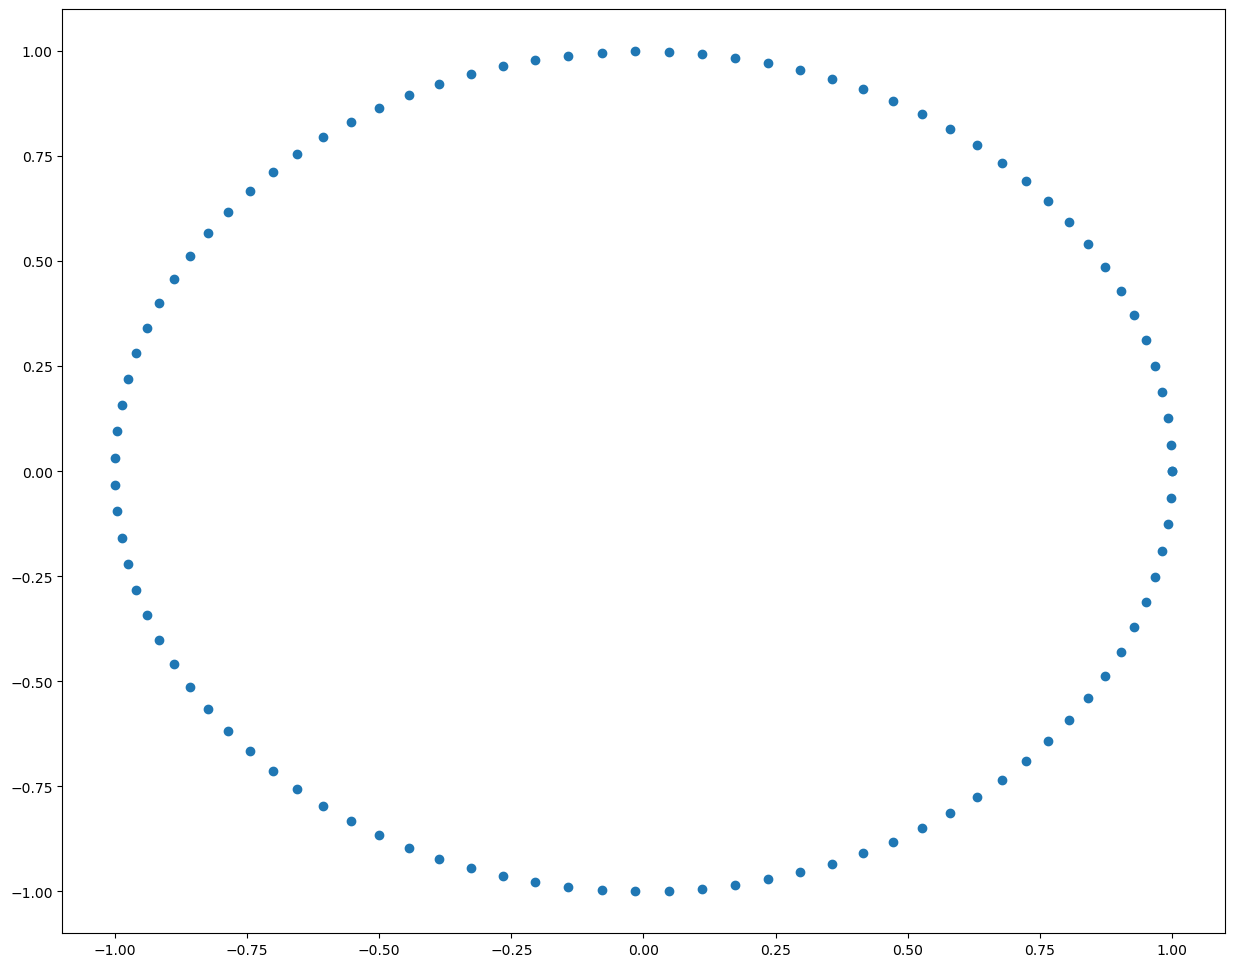

In [340]:
# Creating the theta and phi values.
N_points = 100
phi = jnp.linspace(0.0, jnp.pi*2, N_points)
X1_circle = jnp.cos(phi)
X2_circle = jnp.sin(phi)
X_circle = jnp.concatenate((X1_circle.reshape(1,-1), X2_circle.reshape(1,-1))).T

fig = plt.figure()
plt.scatter(X1_circle, X2_circle)
plt.show()

### Simulating Brownian Motion on Sphere

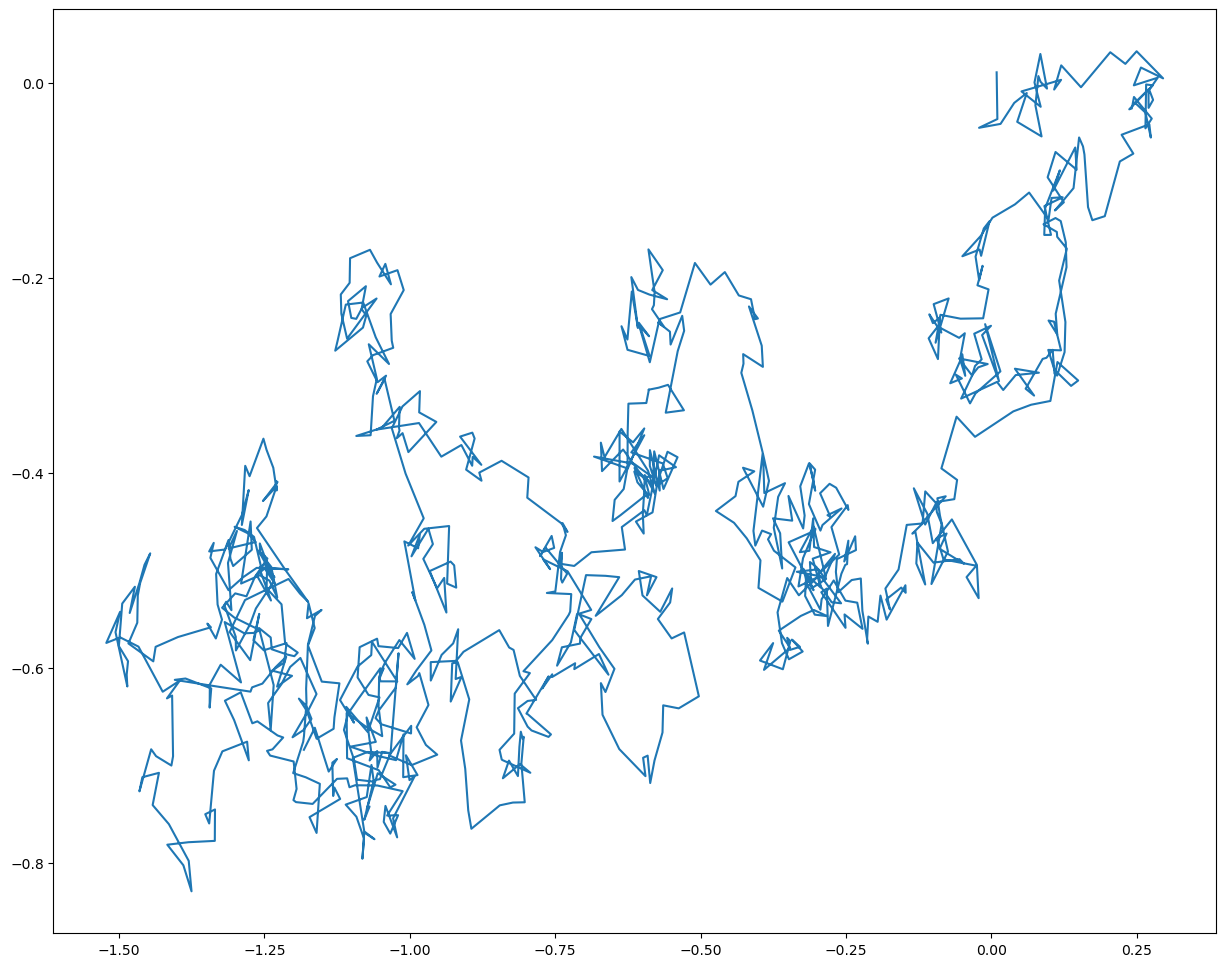

In [341]:
_dts = dts(T = T, n_steps=1000)
(ts,xs,charts) = M.Brownian_coords(x0,_dts,dWs(M.dim,_dts))

X_bm = (xs, charts)

# plot
fig = plt.figure()
plt.plot(X_bm[0][:,0], X_bm[0][:,1])
plt.show()

## Theoretical Heat Kernel in Euclidean Space

The heat kernel in $\mathbb{R}^{m}$ is given by

\begin{equation}
    p(x,y,t) = \frac{1}{(2\pi t)^{m/2}}e^{-\frac{-||x-y||^{2}}{2t}},
\end{equation}

which implies that

\begin{equation}
    \log p(x,y,t) = -\frac{||x-y||^{2}}{2t}-\frac{m}{2}\log\left(2\pi t\right)
\end{equation}

Thus

\begin{equation}
    \nabla_{x} \log p(x,y,t) = \frac{y-x}{t}
\end{equation}

In [352]:
def p_sm(x,y,t, m=2):
    
    const = (2*jnp.pi*t)**(m/2)
    
    return jnp.exp(-jnp.sum((x-y)**2)/(2*t))/const
    
def grad_log_p_sm(x,y,t):
    
    return -(y-x)/t

The following plot displays the heat kernel on the sphere

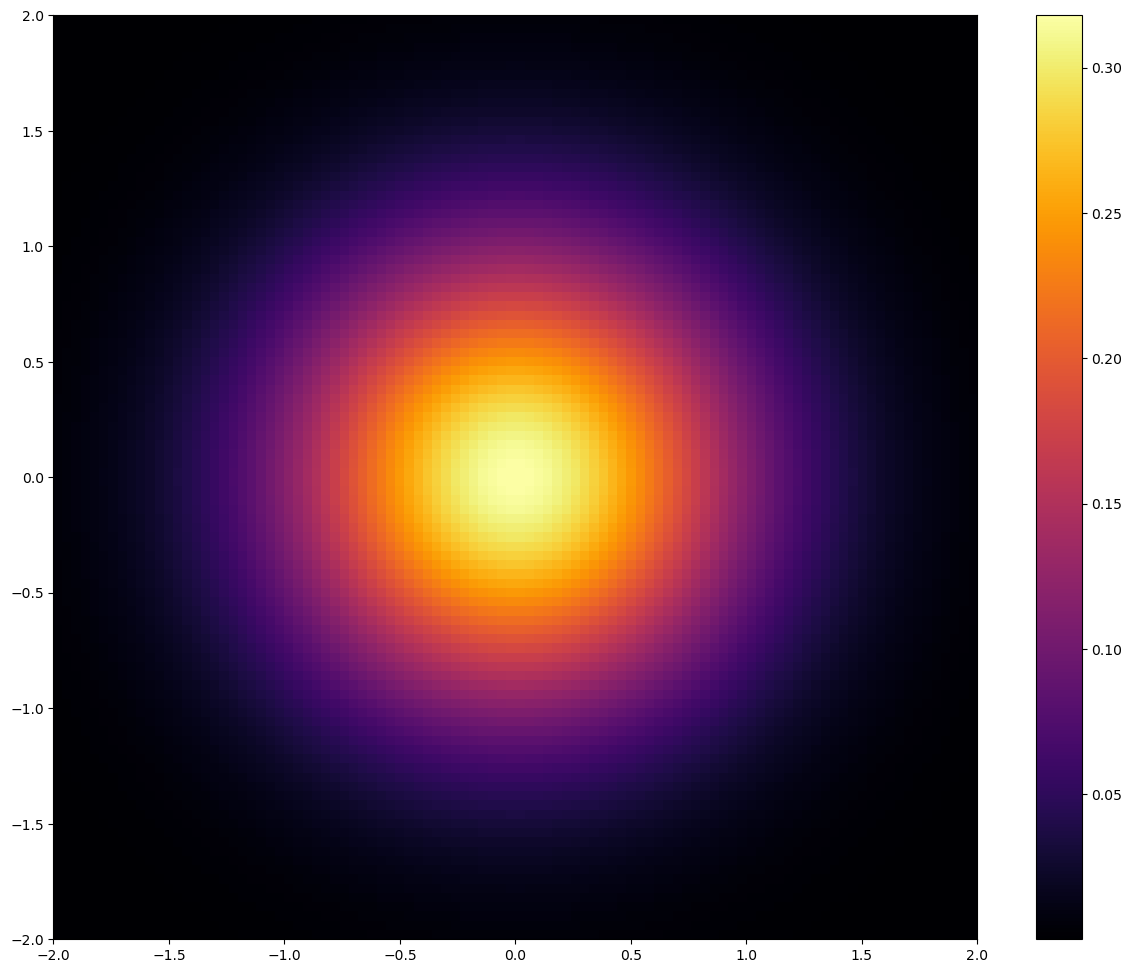

In [353]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values.
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, intervals, intervals), 
                     X2.reshape(1, intervals, intervals))), axes=(1,2,0))

heat_map = vmap(lambda x2: vmap(lambda x1: p_sm(x0[-1], x1, T))(x2))(X)

# Creating the plot.
fig = plt.figure()
plt.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
plt.colorbar(m)

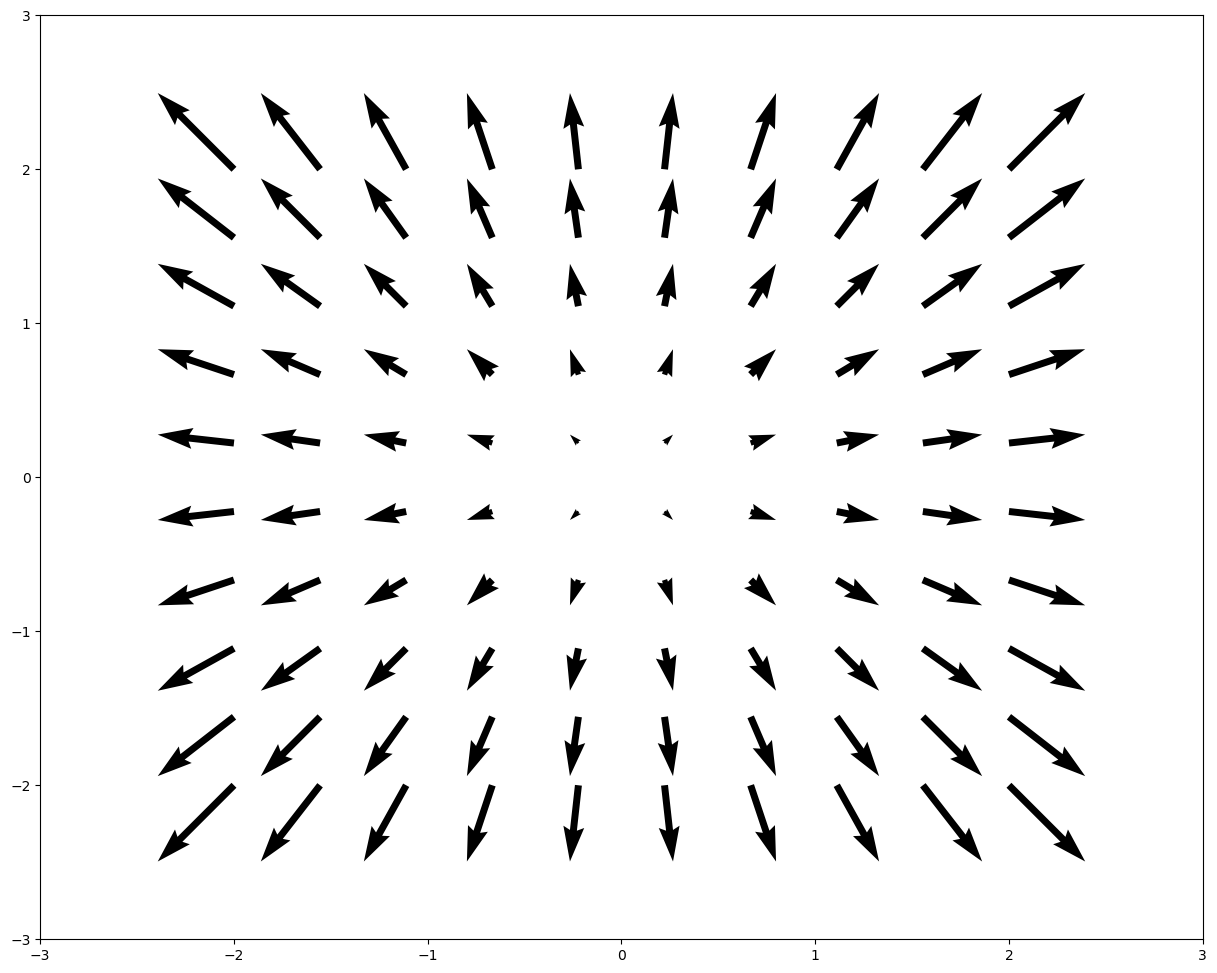

In [354]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points), 
                     X2.reshape(1, N_points, N_points))), axes=(1,2,0))
                  
grad_log = -vmap(lambda x1: vmap(lambda x2: grad_log_p_sm(x0[0], x2, T))(x1))(X)

fig = plt.figure()
plt.quiver(X1, X2, grad_log[:,:,0], grad_log[:,:,1])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.show()

## Diffusion Mean

In [355]:
#%% Modules

import jax.numpy as jnp
from jax import vmap, jit, lax

#%% Code

def diffusion_mean(M, X_obs, gradlog_hk_fun, T = 1.0, eta = 0.1,
                   mu_init=None, _iter = 100):
    
    def gradient_descent_step(mu, dummy):
        
        mu = M.Exp(mu, -eta*grad_error(mu))
        
        return mu, None
    
    if mu_init is None:
        mu_init = get_coords(X_obs[0])
        
    grad_error = jit(lambda mu: -jnp.sum(vmap(lambda y: gradlog_hk_fun(mu[0], y, T))(X_obs), axis=0))
        
    yT, _ = lax.scan(gradient_descent_step, mu_init, xs=jnp.arange(0, _iter, 1))
            
    return yT

In [356]:
test = diffusion_mean(M, X_circle, grad_log_p_sm, T=T, eta = 0.001, mu_init = None, _iter=100)

print(test)
print(x0)

test = diffusion_mean(M, X_bm[0], grad_log_p_sm, T=T, eta = 0.001, mu_init = None, _iter=100)

print(test)


(Array([ 8.1989744e+07, -2.4263552e-01], dtype=float32), Array([0.], dtype=float32))
(Array([0., 0.], dtype=float32), Array([0.], dtype=float32))
(Array([nan, nan], dtype=float32), Array([0.], dtype=float32))


## Learning $\nabla_{x}\log p$ using theoretical gradient

Some text here

### Learning $\nabla_{x}\log p$ for fixed $x_{0}$ and $T$

In [357]:
#Hyper parameters
learning_rate = 0.001
epochs = 100
batch_size = 2**5
samples_size = batch_size*2**4
maxiter = epochs * samples_size // batch_size

In [358]:
#Uniform generator
def generator_unif():
    while True:
        """Generates batches of samples."""

        x1 = np.random.uniform(low = -2.0, high = 2.0, size=batch_size)
        x2 = np.random.uniform(low = -2.0, high = 2.0, size=batch_size)

        yield jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1))).T


In [359]:
#Brownian generator
_dts = dts(T=T)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = batch_size
        (ts,xss,chartss,*_) = product(tile(x0,N),
                                      _dts,
                                      dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]

        yield samples

In [360]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(10), jax.nn.tanh,
        hk.Linear(5), jax.nn.tanh,
        hk.Linear(2),
    ])
#     y = jax.vmap(to_TM)(x.reshape([-1,M.emb_dim]),model(x.reshape([-1,M.emb_dim]))).reshape(x.shape)
    y = model(x)
    return y

In [361]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    true_s = vmap(lambda x1: grad_log_p_sm(x0[-1], x1, T))(data)

    return jnp.linalg.norm(s-true_s)**2

In [362]:
#Data loader
#generator = generator_unif #Generate uniformly distirbuted numbers
generator = generator_bm #Generate from Browninan motion in x0
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.sgd(learning_rate) #Adam Optimizer
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 60.911.
[Step 20], epoch 1, training loss: 30.192.
[Step 30], epoch 1, training loss: 35.538.
[Step 40], epoch 2, training loss: 17.531.
[Step 50], epoch 3, training loss: 14.342.
[Step 60], epoch 3, training loss: 5.748.
[Step 70], epoch 4, training loss: 5.171.
[Step 80], epoch 5, training loss: 5.476.
[Step 90], epoch 5, training loss: 4.744.
[Step 100], epoch 6, training loss: 5.031.
[Step 110], epoch 6, training loss: 3.304.
[Step 120], epoch 7, training loss: 5.865.
[Step 130], epoch 8, training loss: 4.195.
[Step 140], epoch 8, training loss: 14.868.
[Step 150], epoch 9, training loss: 3.114.
[Step 160], epoch 10, training loss: 9.564.
[Step 170], epoch 10, training loss: 11.734.
[Step 180], epoch 11, training loss: 5.922.
[Step 190], epoch 11, training loss: 3.954.
[Step 200], epoch 12, training loss: 6.611.
[Step 210], epoch 13, training loss: 2.478.
[Step 220], epoch 13, training loss: 2.963.
[Step 230]

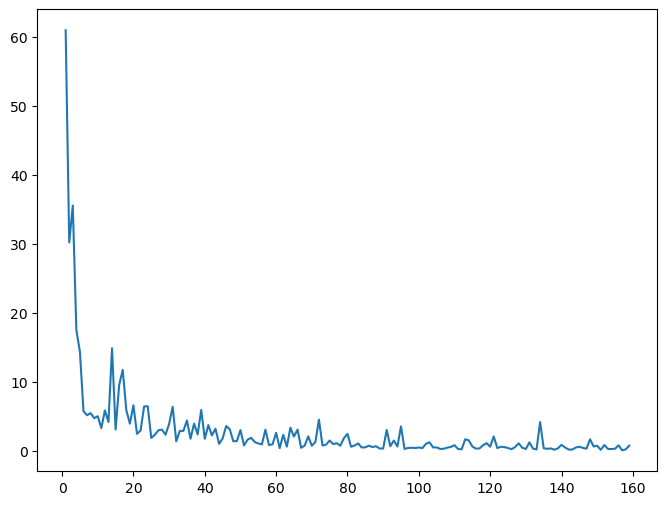

In [363]:
plt.figure(figsize=(8,6))
plt.plot(loss)

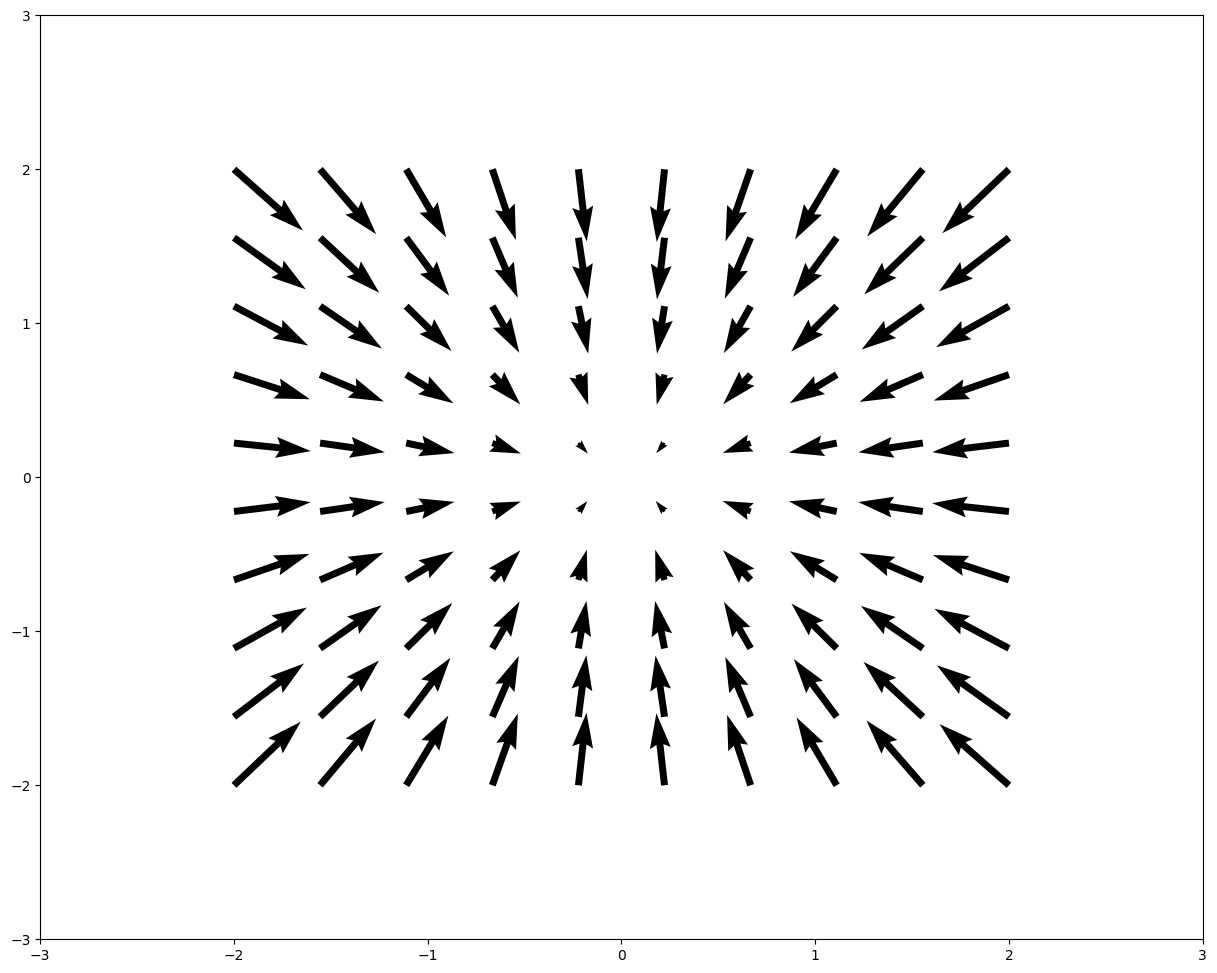

In [364]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points), 
                     X2.reshape(1, N_points, N_points))), axes=(1,2,0))
                  
grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params, x2))(x1))(X)

fig = plt.figure()
plt.quiver(X1, X2, grad_log[:,:,0], grad_log[:,:,1])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.show()

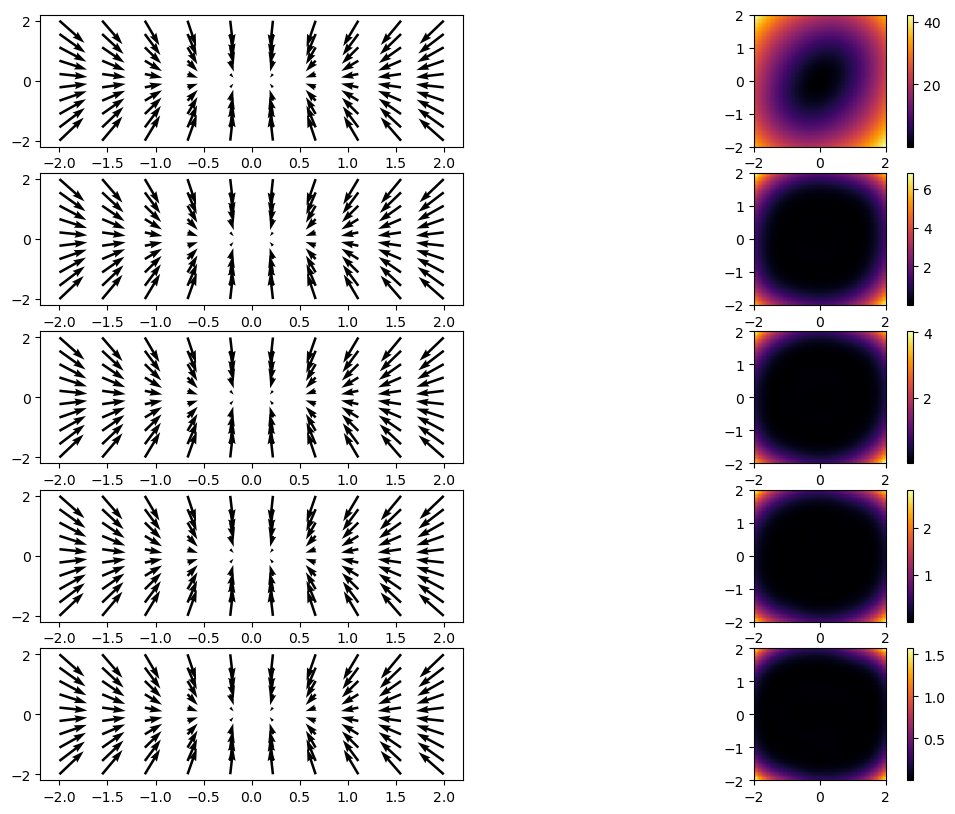

In [365]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,x2))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],Fx)
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1)
    ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2)
    ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,Fx)
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1)
ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ for fixed $T$

In [366]:
#Hyper parameters
learning_rate = 0.001 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
samples_per_x0 = 2**5
repeats = 2**3
batch_size = samples_per_x0*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [367]:
#Uniform generator
def generator_unif():
    while True:
        """Generates batches of samples."""
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        
        x0 = jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1))).T
        x0 = jnp.repeat(x0, samples_per_x0, axis=0)
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        
        xT = jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1))).T
        
        yield jnp.hstack((x0, xT))

In [368]:
global x0s
x0s = tile(x0,batch_size)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = batch_size
        _dts = dts(T=T)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]
        charts = chartss[-1]
        Fx0s = x0s[0]
        x0s = (jnp.repeat(samples[::samples_per_x0],samples_per_x0,axis=0),
               jnp.repeat(charts[::samples_per_x0],samples_per_x0,axis=0))
        yield jnp.hstack((Fx0s,samples))

In [369]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(30), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(2),
    ])
#     y = jnp.squeeze(jax.vmap(to_TM)(x.reshape([-1,2*M.emb_dim])[:,M.emb_dim:],model(x.reshape([-1,2*M.emb_dim]))))
    y = model(x)
    return y

In [370]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    Fx0s = data[:,0:2]
    Fxts = data[:,2:2*2]
    #true_s = vmap(lambda x0, x1, t: to_TM(x0,grad_log_p_sm(x0, x1, t)))(Fx0s, Fxts, ts)
    true_s = vmap(lambda x0, x1: grad_log_p_sm(x0, x1, T))(Fx0s, Fxts)
    
    return jnp.linalg.norm(s-true_s)**2

In [371]:
#generator = generator_unif
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2*2]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 878.276.
[Step 20], epoch 1, training loss: 943.357.
[Step 30], epoch 1, training loss: 889.049.
[Step 40], epoch 2, training loss: 783.271.
[Step 50], epoch 3, training loss: 778.143.
[Step 60], epoch 3, training loss: 788.941.
[Step 70], epoch 4, training loss: 786.652.
[Step 80], epoch 5, training loss: 845.695.
[Step 90], epoch 5, training loss: 660.009.
[Step 100], epoch 6, training loss: 623.166.
[Step 110], epoch 6, training loss: 612.294.
[Step 120], epoch 7, training loss: 491.720.
[Step 130], epoch 8, training loss: 403.129.
[Step 140], epoch 8, training loss: 343.170.
[Step 150], epoch 9, training loss: 235.871.
[Step 160], epoch 10, training loss: 199.529.
[Step 170], epoch 10, training loss: 170.538.
[Step 180], epoch 11, training loss: 135.462.
[Step 190], epoch 11, training loss: 109.757.
[Step 200], epoch 12, training loss: 104.108.
[Step 210], epoch 13, training loss: 73.002.
[Step 220], epoch 13

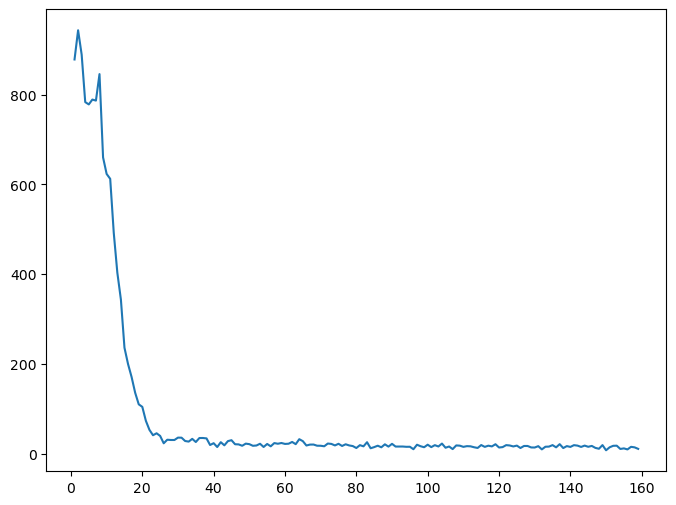

In [372]:
plt.figure(figsize=(8,6))
plt.plot(loss)

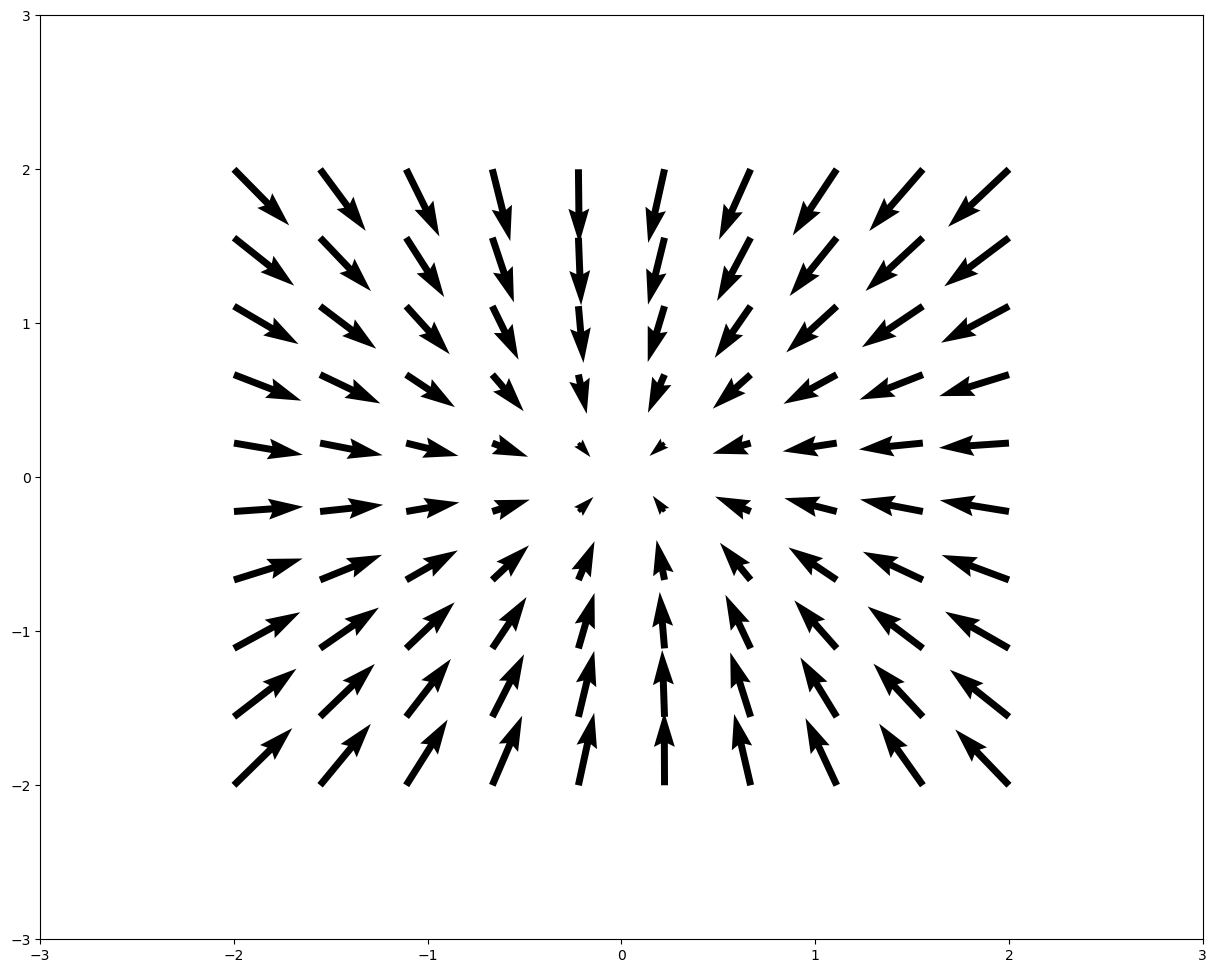

In [373]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points), 
                     X2.reshape(1, N_points, N_points))), axes=(1,2,0))
                  
grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params, jnp.hstack((x0[0], x2))))(x1))(X)

fig = plt.figure()
plt.quiver(X1, X2, grad_log[:,:,0], grad_log[:,:,1])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.show()

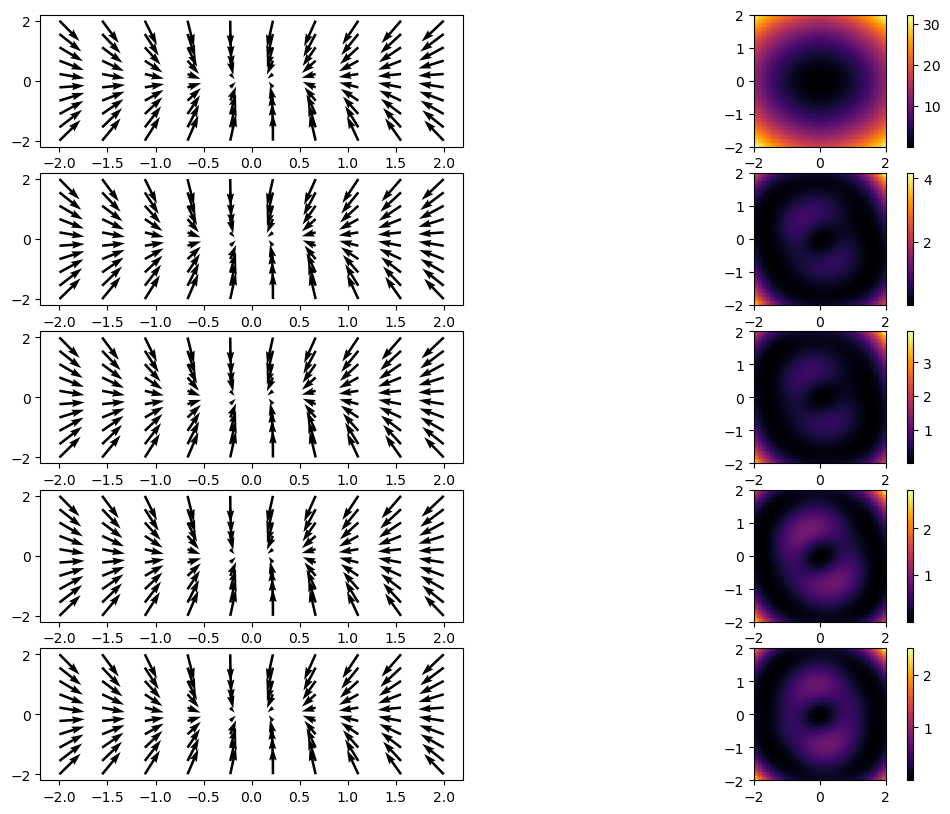

In [374]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x0[0], x2))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((x0[0], Fx)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1)
    ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2)
    ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((x0[0], Fx)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1)
ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ for fixed $x_{0}$

In [375]:
#Hyper parameters
learning_rate = 0.0001 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
ts_per_batch = 2**4
repeats = 2**5
batch_size = ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [376]:
#Uniform generator
def generator_unif():
    while True:
        """Generates batches of samples."""
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        
        xT = jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1))).T
        t = np.repeat(np.random.uniform(low = 0.0, high = 1.0, size=ts_per_batch), repeats)
        
        yield jnp.hstack((xT, t.reshape(-1, 1)))

In [377]:
global x0s
x0s = tile(x0,repeats)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = repeats
        _dts = dts(T=max_T)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))        
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([49,99])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((samples.reshape((-1,M.dim)),
                         jnp.repeat(ts.reshape((-1,1)),N,axis=1).reshape((-1,1))
                        ))

In [378]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(100), jax.nn.tanh,
        hk.Linear(50), jax.nn.tanh,
        hk.Linear(2),
    ])
    y = model(x)
    return y

In [379]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    Fxts = data[:,0:2]
    ts = data[:,-1]
    #true_s = vmap(lambda x0, x1, t: to_TM(x0,grad_log_p_sm(x0, x1, t)))(Fx0s, Fxts, ts)
    true_s = vmap(lambda x1, t: grad_log_p_sm(x0[-1], x1, t))(Fxts, ts)
    
    return jnp.linalg.norm(s-true_s)**2

In [380]:
#generator = generator_unif
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2+1]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 5204.188.
[Step 20], epoch 1, training loss: 4559.897.
[Step 30], epoch 1, training loss: 1074.429.
[Step 40], epoch 2, training loss: 733.439.
[Step 50], epoch 3, training loss: 2312.252.
[Step 60], epoch 3, training loss: 1551.084.
[Step 70], epoch 4, training loss: 1914.226.
[Step 80], epoch 5, training loss: 4338.821.
[Step 90], epoch 5, training loss: 1058.499.
[Step 100], epoch 6, training loss: 695.961.
[Step 110], epoch 6, training loss: 4711.624.
[Step 120], epoch 7, training loss: 1252.247.
[Step 130], epoch 8, training loss: 700.243.
[Step 140], epoch 8, training loss: 2423.703.
[Step 150], epoch 9, training loss: 1113.517.
[Step 160], epoch 10, training loss: 1302.729.
[Step 170], epoch 10, training loss: 512.713.
[Step 180], epoch 11, training loss: 1385.437.
[Step 190], epoch 11, training loss: 1024.304.
[Step 200], epoch 12, training loss: 4099.596.
[Step 210], epoch 13, training loss: 7808.363.
[S

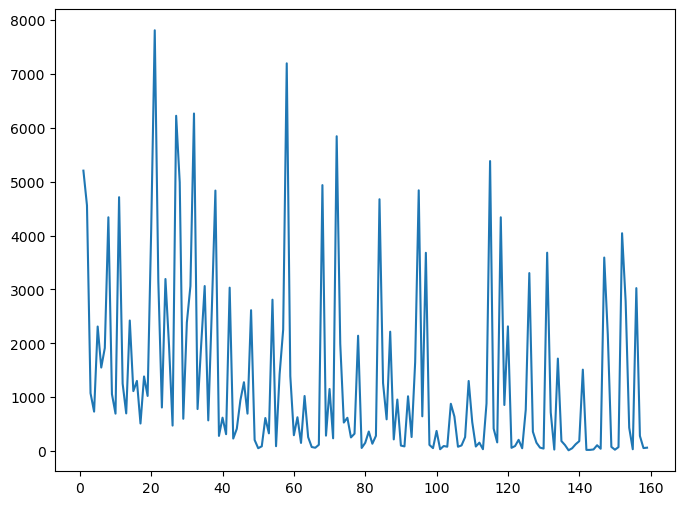

In [381]:
plt.figure(figsize=(8,6))
plt.plot(loss)

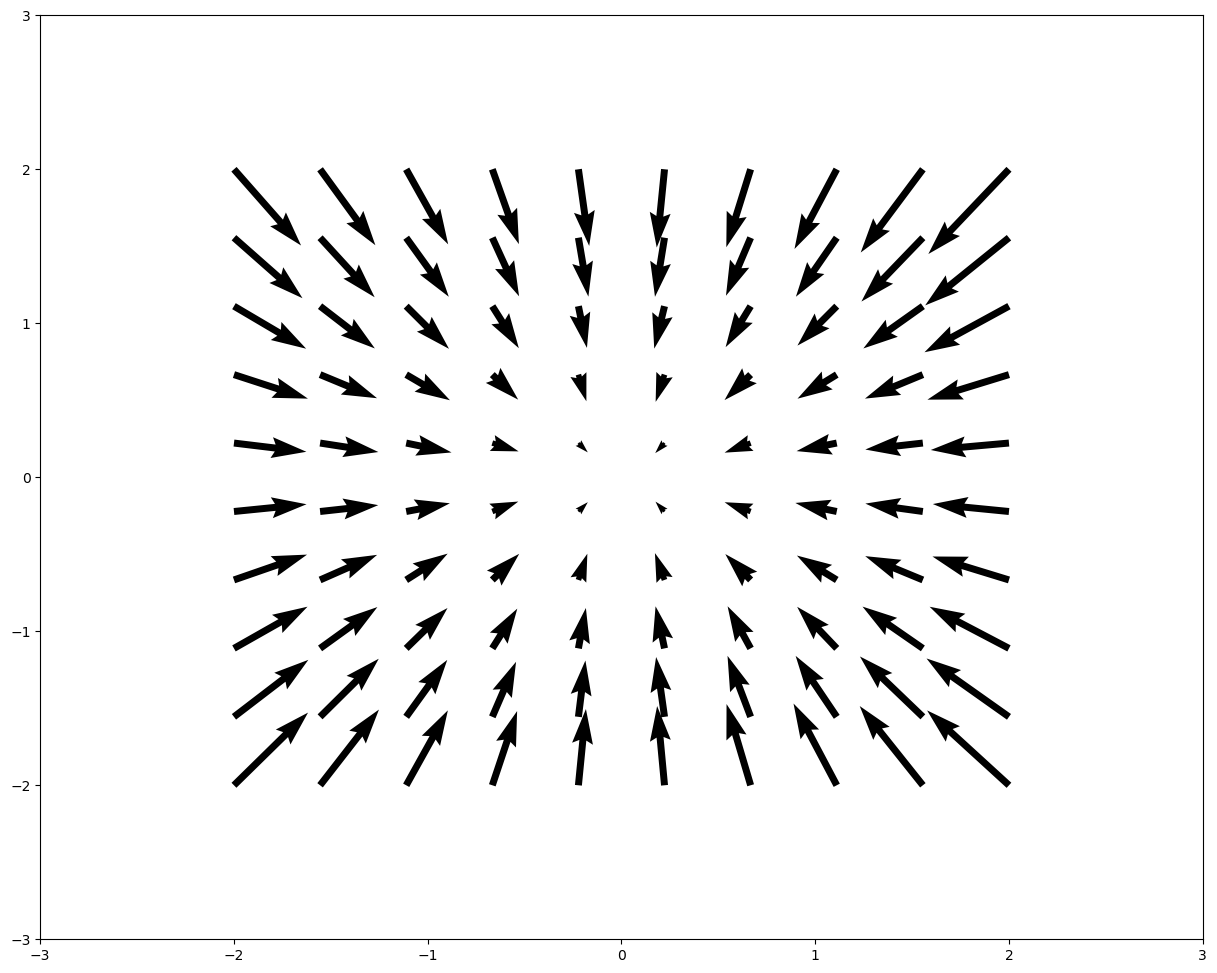

In [382]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points), 
                     X2.reshape(1, N_points, N_points))), axes=(1,2,0))
                  
grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params, jnp.hstack((x2, T))))(x1))(X)

fig = plt.figure()
plt.quiver(X1, X2, grad_log[:,:,0], grad_log[:,:,1])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.show()

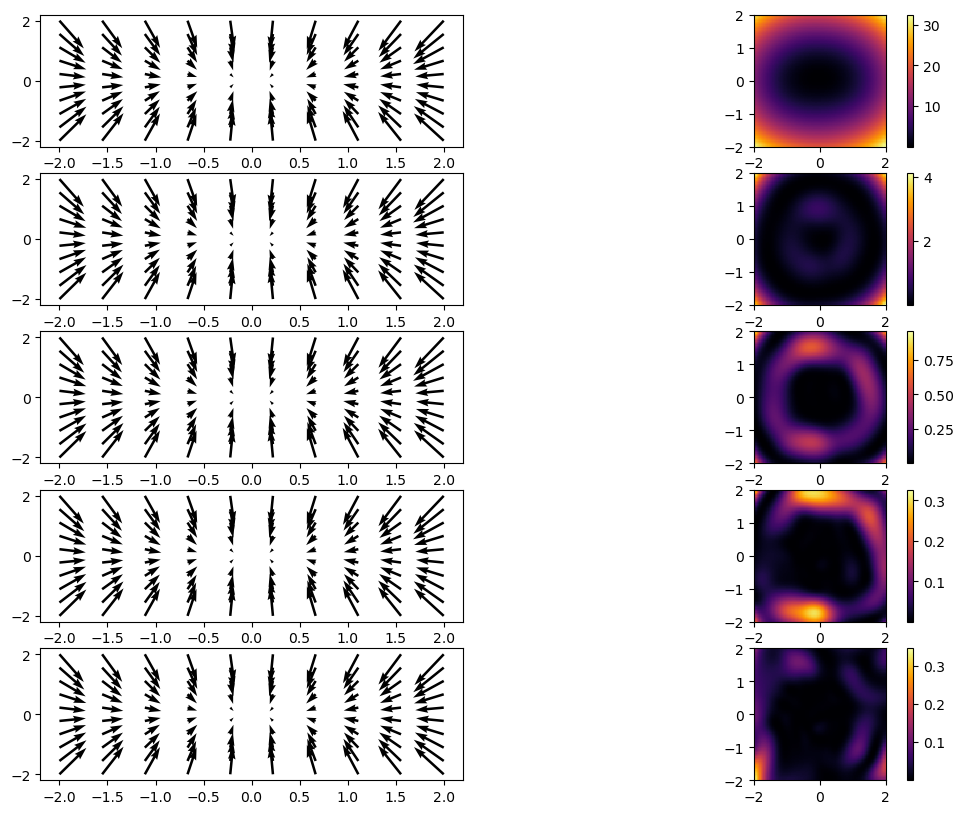

In [383]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x2, T))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((Fx, T)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1)
    ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2)
    ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((Fx, T)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1)
ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ in general

In [384]:
#Hyper parameters
learning_rate = 0.0001 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
samples_per_x0 = 2**5
ts_per_batch = 2**7
repeats = 2**3
batch_size = samples_per_x0*ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [385]:
#Uniform generator
def generator_unif():
    while True:
        """Generates batches of samples."""
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        
        x0 = jnp.repeat(jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1))).T,
                        ts_per_batch*samples_per_x0, axis=0)
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        
        xT = jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1))).T
        t = np.repeat(np.random.uniform(low = 0.0, high = 1.0, size=ts_per_batch), repeats*samples_per_x0)
        
        yield jnp.hstack((x0, xT, t.reshape(-1, 1)))

In [386]:
global x0s
x0s = tile(x0,repeats)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = samples_per_x0*repeats
        _dts = dts(T=max_T)
        global x0s
        (ts,xss,chartss,*_) = product((jnp.repeat(x0s[0],samples_per_x0,axis=0),jnp.repeat(x0s[1],samples_per_x0,axis=0)),
                                      _dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        Fx0s = jax.vmap(lambda x,chart: M.F((x,chart)))(*x0s)
        x0s = (xss[-1,::samples_per_x0],chartss[-1,::samples_per_x0])
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([-1,-1])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((jnp.tile(jnp.repeat(Fx0s,samples_per_x0,axis=0),(ts_per_batch,1)),
                         samples.reshape(-1, M.dim),
                         jnp.repeat(ts,N).reshape((-1,1))
                        ))

In [387]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(100), jax.nn.tanh,
        hk.Linear(50), jax.nn.tanh,
        hk.Linear(2),
    ])
    
    y = model(x)
    
    return y

In [388]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    Fx0s = data[:,0:2]
    Fxts = data[:,2:2*2]
    ts = data[:,-1]
    #true_s = vmap(lambda x0, x1, t: to_TM(x0,grad_log_p_sm(x0, x1, t)))(Fx0s, Fxts, ts)
    true_s = vmap(lambda x0, x1, t: grad_log_p_sm(x0, x1, t))(Fx0s, Fxts, ts)
    
    return jnp.linalg.norm(s-true_s)**2

In [389]:
generator = generator_unif
#generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2*2+1]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 262167609344.000.
[Step 20], epoch 1, training loss: 287028384.000.
[Step 30], epoch 1, training loss: 42878288.000.
[Step 40], epoch 2, training loss: 130119496.000.
[Step 50], epoch 3, training loss: 28204951552.000.
[Step 60], epoch 3, training loss: 109325608.000.
[Step 70], epoch 4, training loss: 238544400.000.
[Step 80], epoch 5, training loss: 3875435008.000.
[Step 90], epoch 5, training loss: 713574784.000.
[Step 100], epoch 6, training loss: 105882288.000.
[Step 110], epoch 6, training loss: 18213986304.000.
[Step 120], epoch 7, training loss: 26990658.000.
[Step 130], epoch 8, training loss: 50629616.000.
[Step 140], epoch 8, training loss: 61458800.000.
[Step 150], epoch 9, training loss: 83793072.000.
[Step 160], epoch 10, training loss: 23301380.000.
[Step 170], epoch 10, training loss: 165733408.000.
[Step 180], epoch 11, training loss: 2287410432.000.
[Step 190], epoch 11, training loss: 722742208

[Step 1580], epoch 98, training loss: 227074960.000.
[Step 1590], epoch 99, training loss: 19258340.000.


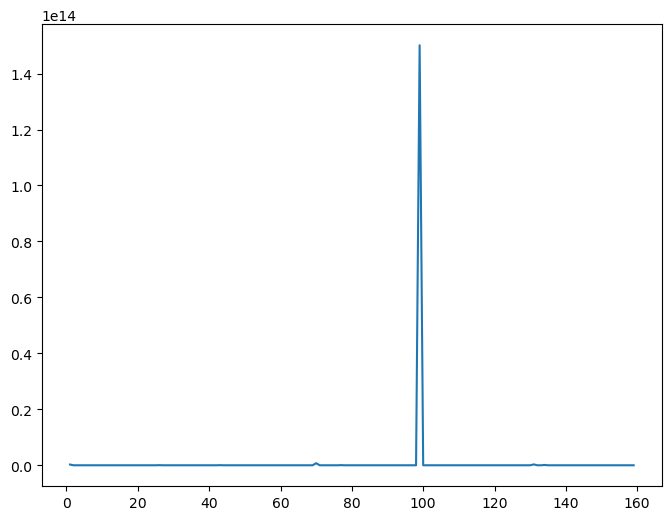

In [390]:
plt.figure(figsize=(8,6))
plt.plot(loss)

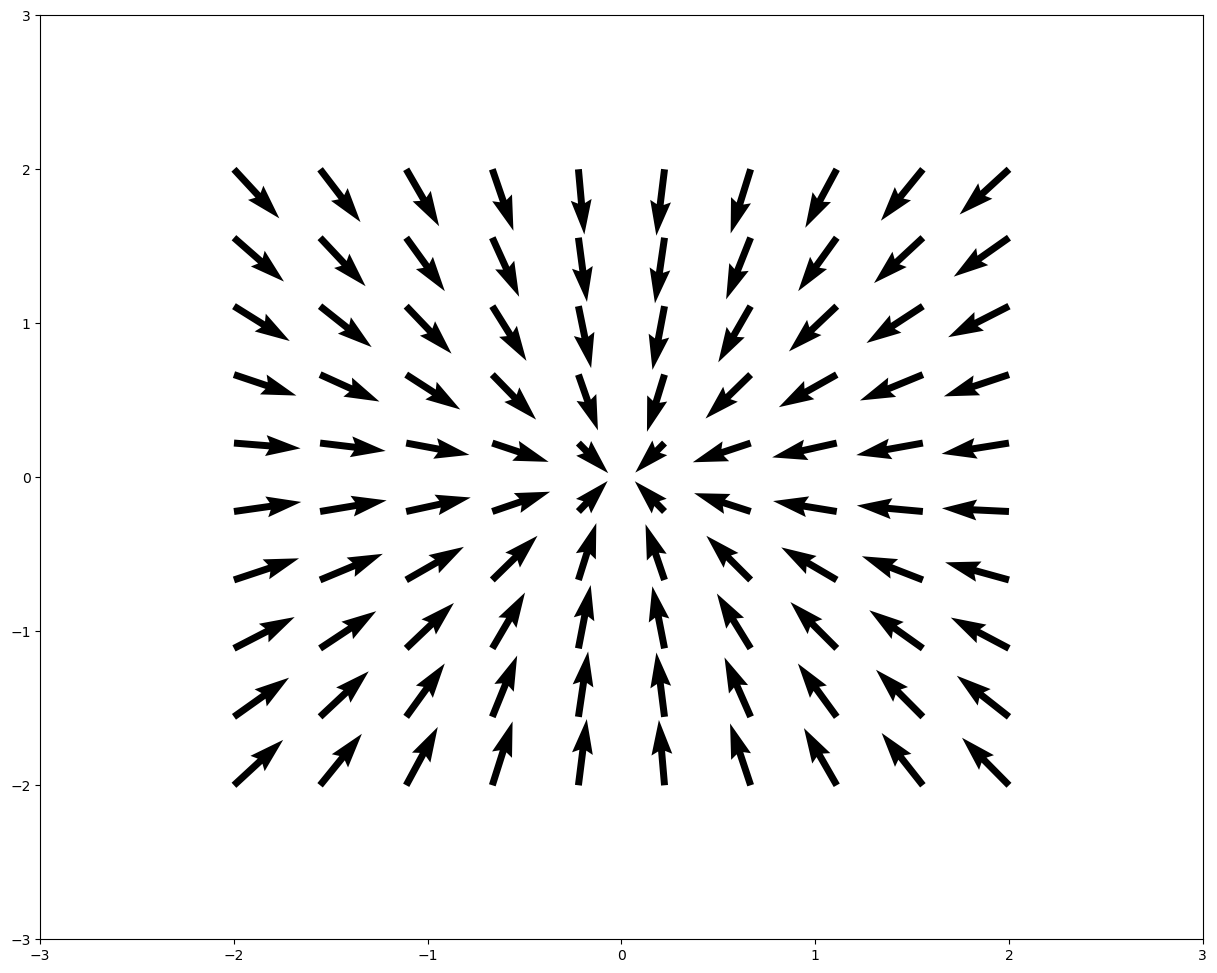

In [391]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points), 
                     X2.reshape(1, N_points, N_points))), axes=(1,2,0))
                  
grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params, jnp.hstack((x0[0], x2, T))))(x1))(X)

fig = plt.figure()
plt.quiver(X1, X2, grad_log[:,:,0], grad_log[:,:,1])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.show()

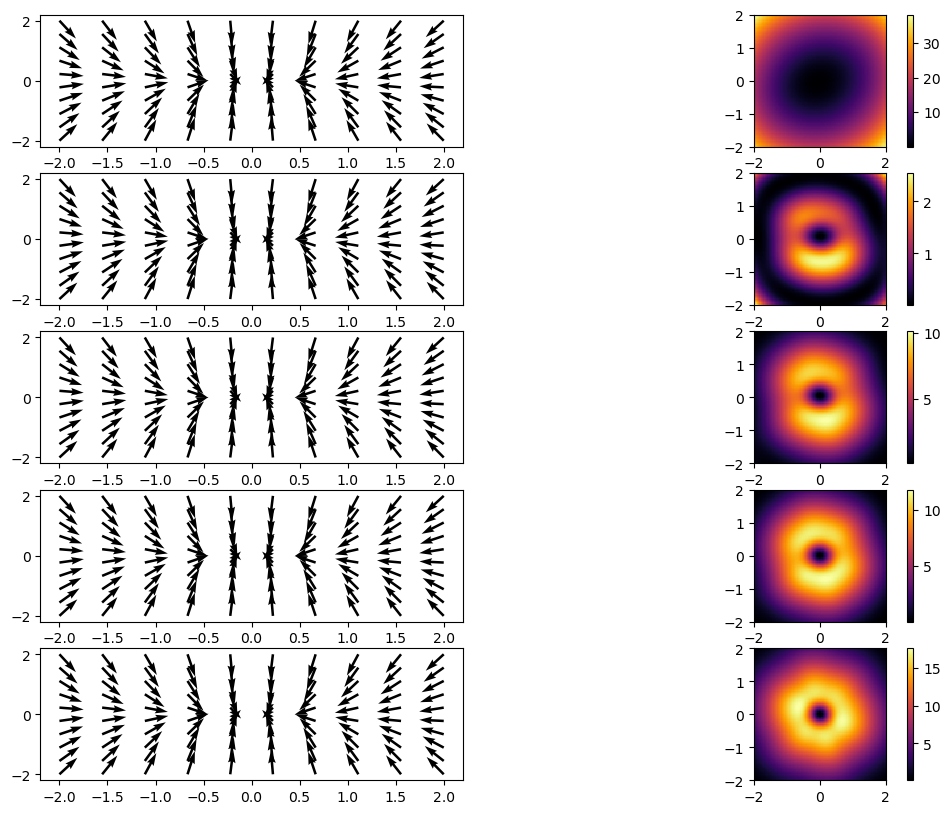

In [392]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x0[0], x2, T))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((x0[0], Fx, T)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1)
    ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2)
    ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((x0[0], Fx, T)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1)
ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

## Learning $\nabla_{x}\log p$

Following "Riemannian Score-Based Generative Modelling" by Bortoli et. al. it follows that

\begin{equation}
    \nabla_{x} \log p(x, y, t) = \int_{\mathcal{M}} \nabla_{x}p(x,y,t) \,\mathbb{P}_{s|t}(x_{t}, \,dx_{s}),
\end{equation}

can be minimized as

\begin{equation}
    \mathcal{l}_{t|s} = \int_{\mathcal{M}^{2}} ||\nabla_{x} \log p(x,y,t) - s_{\theta}(x,t)||,
\end{equation}

where $s_{\theta}$ is a neural network with parameters $\theta$. Using integration by parts it follows that

\begin{equation}
    \mathcal{l}_{t|s} = \int_{\mathcal{M}} \left(||s(x,t)||^{2} + 2\text{div}\left(s_{t}\right)(x_{t})\right)\,d\mathbb{P}_{t}(x_{t})+\int_{\mathcal{M}^{2}}||\nabla_{x}\log p_{t|s}(x_{t}|x_{s})\,d\mathbb{P}_{s,t}(x_{s},x_{t}),
\end{equation}

where the latter term is independent of $s_{\theta}$.

### Learning $\nabla_{x}\log p$ for fixed $x_{0}$ and $T$

In [393]:
#Hyper parameters
learning_rate = 0.001
epochs = 100
batch_size = 2**5
samples_size = batch_size*2**4
maxiter = epochs * samples_size // batch_size

In [394]:
#Brownian generator
_dts = dts(T=T)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = batch_size
        (ts,xss,chartss,*_) = product(tile(x0,N),
                                      _dts,
                                      dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]

        yield samples

In [395]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(10), jax.nn.tanh,
        hk.Linear(5), jax.nn.tanh,
        hk.Linear(2),
    ])
#     y = jax.vmap(to_TM)(x.reshape([-1,M.emb_dim]),model(x.reshape([-1,M.emb_dim]))).reshape(x.shape)
    y = model(x)
    return y

In [396]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    (xs,charts) = jax.vmap(get_coords)(data)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda x,chart,s: M.div((x,chart),
                                            lambda x: net.apply(params,x[0])))(xs,charts,s)
#     # plot
#     newfig()
#     M.plot()
#     for i in range(xs.shape[0]):
#         M.plotx((xs[i],charts[i]))
#     plt.show()
    return jnp.mean(norm2s+2.0*divs)

In [397]:
#Data loader
generator = generator_bm #Generate from Browninan motion in x0
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.sgd(learning_rate) #Adam Optimizer
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 1.696.
[Step 20], epoch 1, training loss: 1.365.
[Step 30], epoch 1, training loss: 1.248.
[Step 40], epoch 2, training loss: 0.968.
[Step 50], epoch 3, training loss: 0.892.
[Step 60], epoch 3, training loss: 0.732.
[Step 70], epoch 4, training loss: 0.527.
[Step 80], epoch 5, training loss: 0.356.
[Step 90], epoch 5, training loss: 0.167.
[Step 100], epoch 6, training loss: 0.051.
[Step 110], epoch 6, training loss: 0.036.
[Step 120], epoch 7, training loss: -0.124.
[Step 130], epoch 8, training loss: -0.274.
[Step 140], epoch 8, training loss: -0.363.
[Step 150], epoch 9, training loss: -0.332.
[Step 160], epoch 10, training loss: -0.705.
[Step 170], epoch 10, training loss: -0.747.
[Step 180], epoch 11, training loss: -0.728.
[Step 190], epoch 11, training loss: -1.042.
[Step 200], epoch 12, training loss: -0.885.
[Step 210], epoch 13, training loss: -1.267.
[Step 220], epoch 13, training loss: -0.870.
[Step 

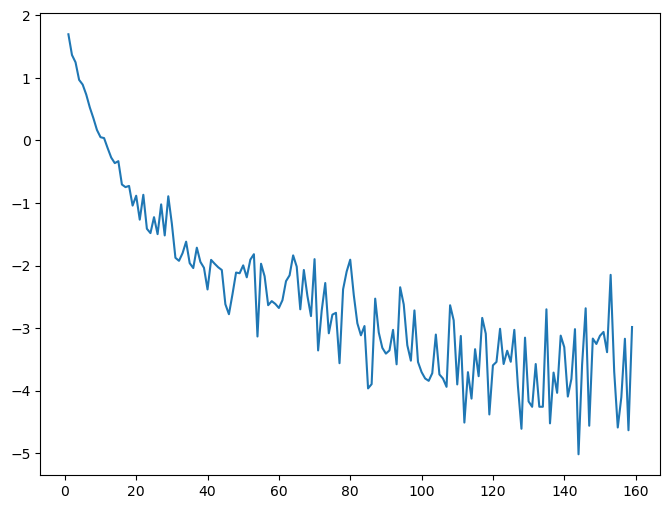

In [398]:
plt.figure(figsize=(8,6))
plt.plot(loss)

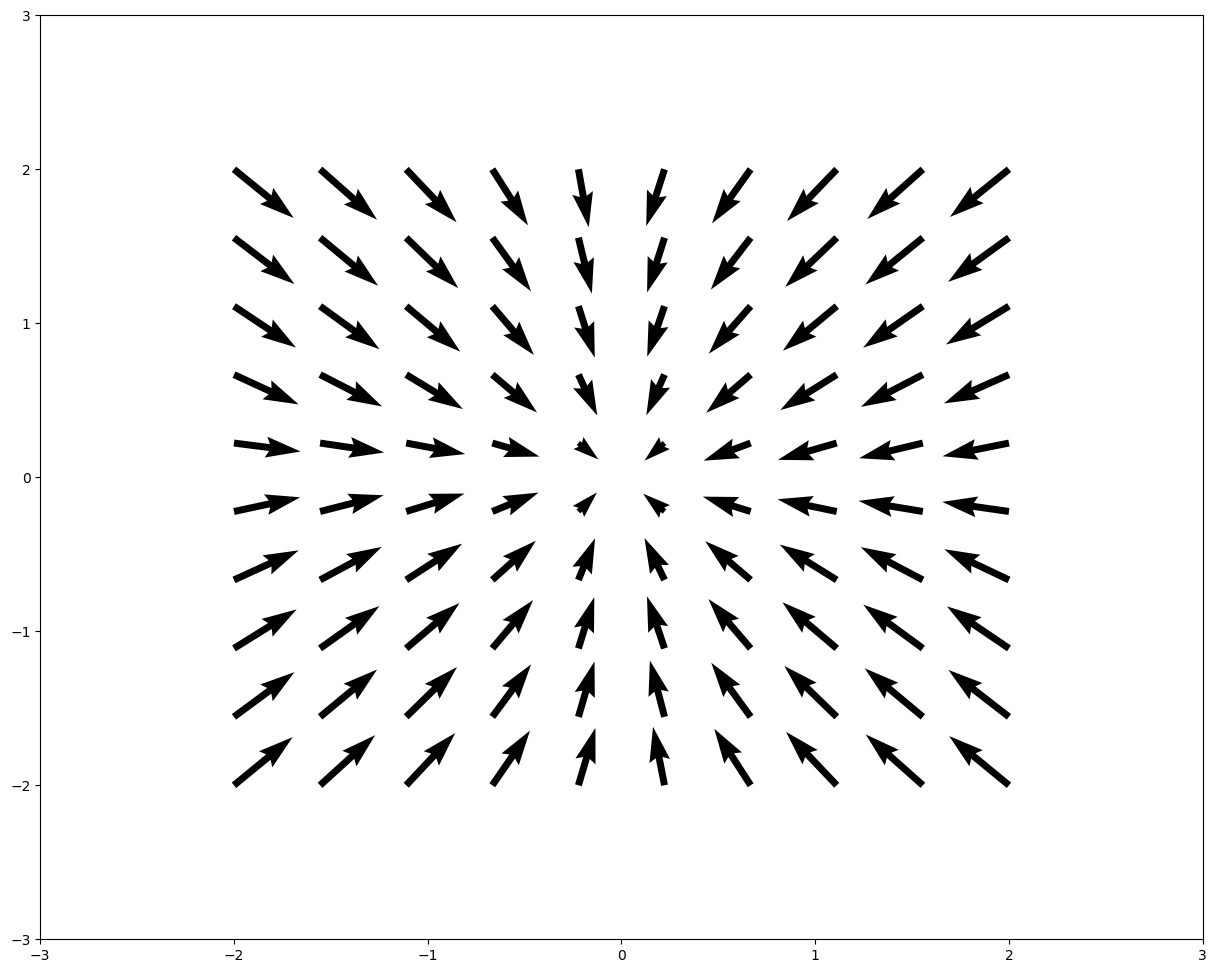

In [399]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points), 
                     X2.reshape(1, N_points, N_points))), axes=(1,2,0))
                  
grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params, x2))(x1))(X)

fig = plt.figure()
plt.quiver(X1, X2, grad_log[:,:,0], grad_log[:,:,1])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.show()

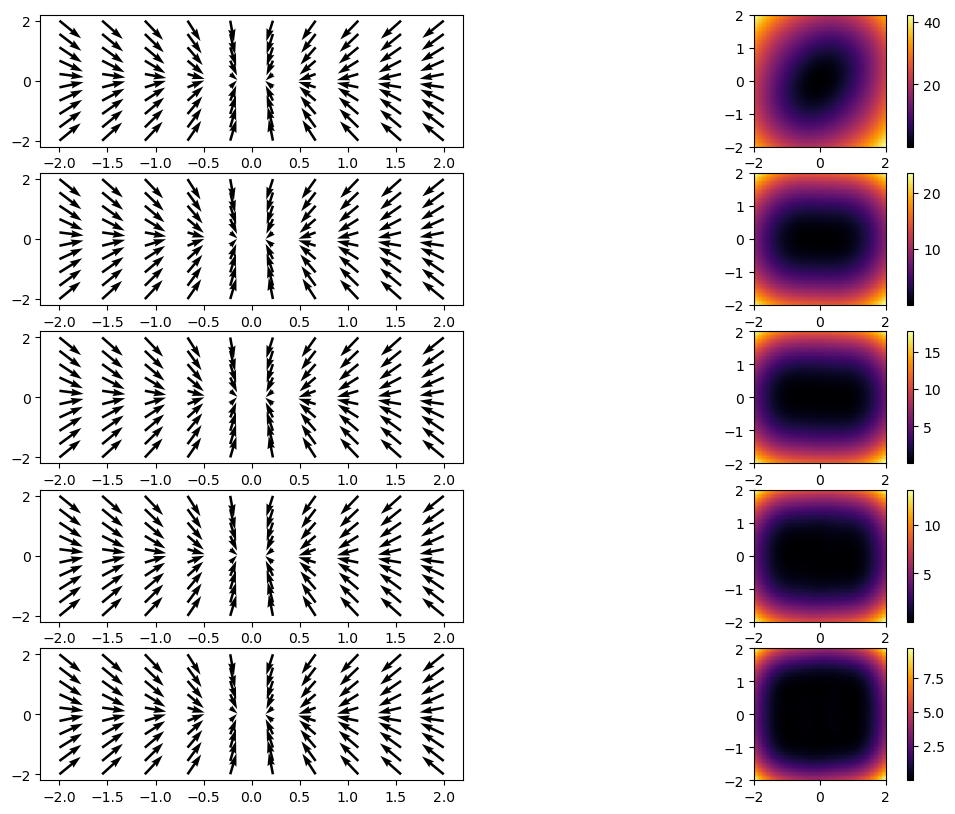

In [400]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,x2))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],Fx)
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1)
    ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2)
    ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,Fx)
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1)
ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ for fixed $T$

In [401]:
#Hyper parameters
learning_rate = 0.01 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
samples_per_x0 = 2**5
repeats = 2**3
batch_size = samples_per_x0*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [402]:
global x0s
x0s = tile(x0,batch_size)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = batch_size
        _dts = dts(T=T)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]
        charts = chartss[-1]
        Fx0s = x0s[0]
        x0s = (jnp.repeat(samples[::samples_per_x0],samples_per_x0,axis=0),
               jnp.repeat(charts[::samples_per_x0],samples_per_x0,axis=0))
        yield jnp.hstack((Fx0s,samples))

In [403]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(80), jax.nn.tanh,
        hk.Linear(40), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(2),
    ])
#     y = jnp.squeeze(jax.vmap(to_TM)(x.reshape([-1,2*M.emb_dim])[:,M.emb_dim:],model(x.reshape([-1,2*M.emb_dim]))))
    y = model(x)
    return y

In [404]:
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params,data)
    Fx0s = data[:,0:2]
    Fxts = data[:,2:]
    (xts,chartts) = jax.vmap(get_coords)(Fxts)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda Fx0,xt,chartt: M.div((xt,chartt),
                                                lambda x: net.apply(params,jnp.hstack((Fx0,x[0]))))
                   )(Fx0s,xts,chartts)
    return jnp.mean(norm2s+2.0*divs)

In [405]:
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2*2]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: -3.266.
[Step 20], epoch 1, training loss: -3.586.
[Step 30], epoch 1, training loss: -3.181.
[Step 40], epoch 2, training loss: -3.533.
[Step 50], epoch 3, training loss: -3.604.
[Step 60], epoch 3, training loss: -3.693.
[Step 70], epoch 4, training loss: -3.705.
[Step 80], epoch 5, training loss: -3.383.
[Step 90], epoch 5, training loss: -3.194.
[Step 100], epoch 6, training loss: -3.400.
[Step 110], epoch 6, training loss: -3.693.
[Step 120], epoch 7, training loss: -3.437.
[Step 130], epoch 8, training loss: -3.778.
[Step 140], epoch 8, training loss: -3.608.
[Step 150], epoch 9, training loss: -3.696.
[Step 160], epoch 10, training loss: -4.061.
[Step 170], epoch 10, training loss: -3.331.
[Step 180], epoch 11, training loss: -3.023.
[Step 190], epoch 11, training loss: -3.279.
[Step 200], epoch 12, training loss: -3.773.
[Step 210], epoch 13, training loss: -3.464.
[Step 220], epoch 13, training loss: -3.

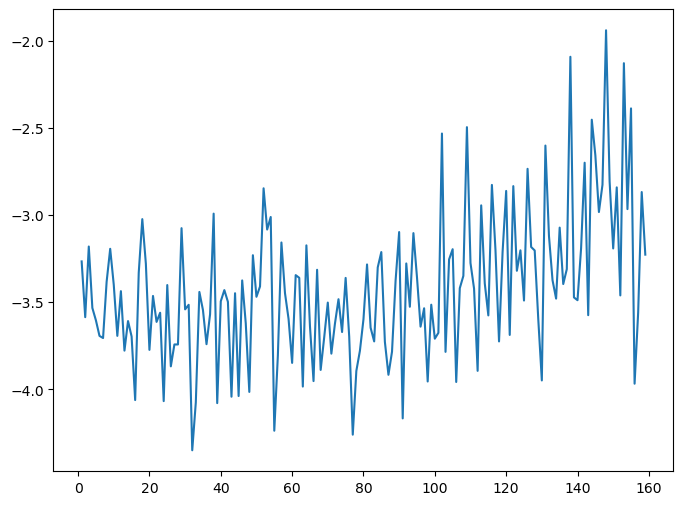

In [406]:
plt.figure(figsize=(8,6))
plt.plot(loss)

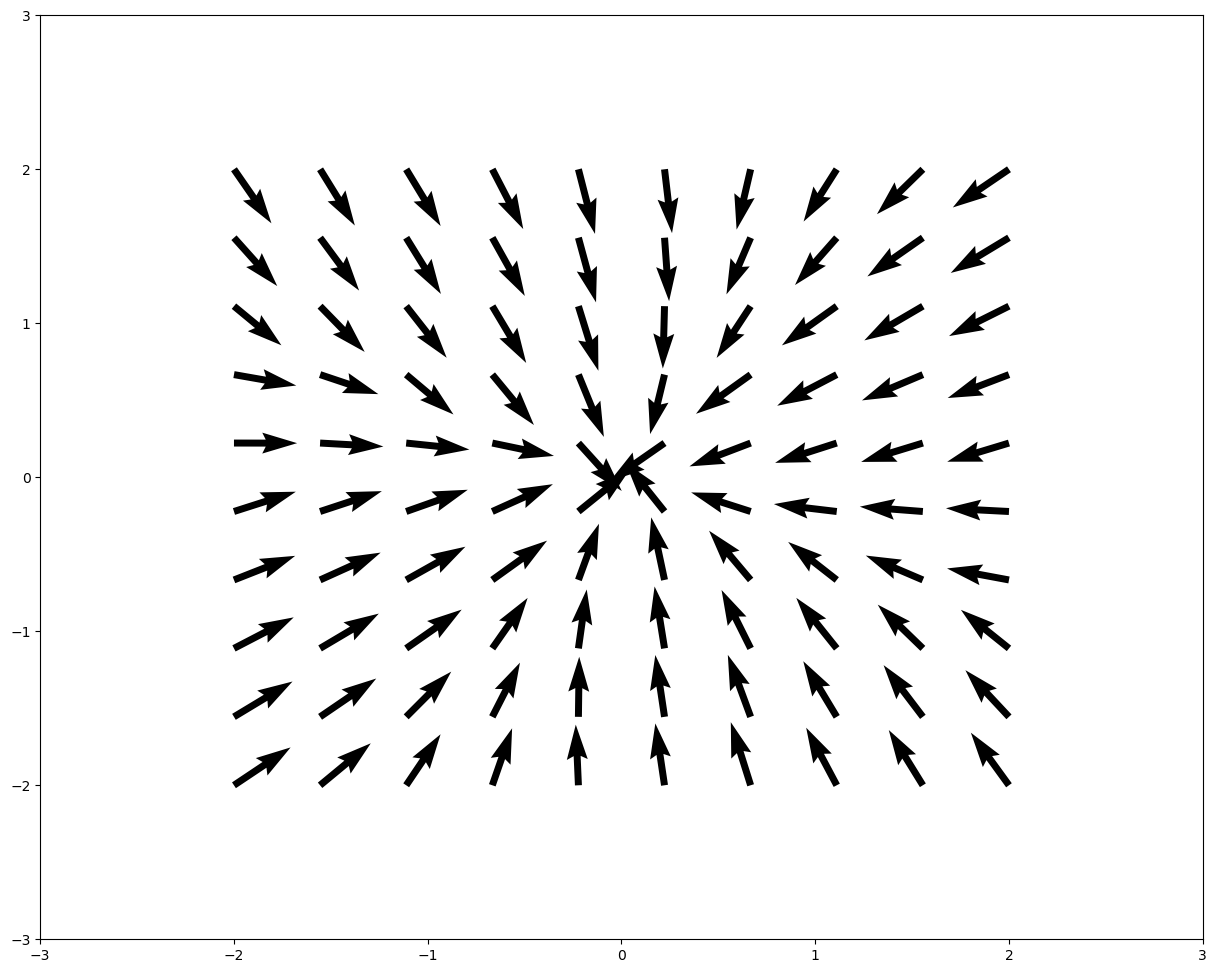

In [407]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points), 
                     X2.reshape(1, N_points, N_points))), axes=(1,2,0))
                  
grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params, jnp.hstack((x0[0], x2))))(x1))(X)

fig = plt.figure()
plt.quiver(X1, X2, grad_log[:,:,0], grad_log[:,:,1])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.show()

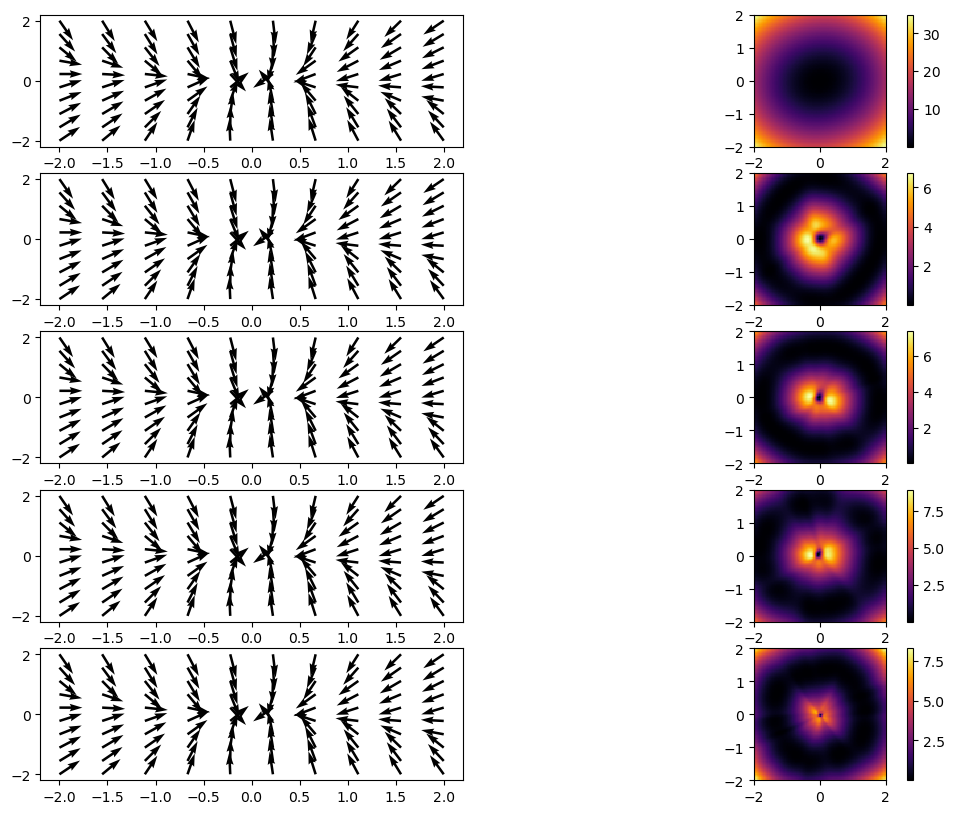

In [408]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x0[0], x2))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((x0[0], Fx)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1)
    ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2)
    ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((x0[0], Fx)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1)
ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ for fixed $x_{0}$

In [409]:
#Hyper parameters
learning_rate = 0.001 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
ts_per_batch = 2**4
repeats = 2**5
batch_size = ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [410]:
global x0s
x0s = tile(x0,repeats)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = repeats
        _dts = dts(T=max_T)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))        
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([49,99])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((samples.reshape((-1, M.dim)),
                         jnp.repeat(ts.reshape((-1,1)),N,axis=1).reshape((-1,1))
                        ))

In [411]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(30), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(2),
    ])
    y = model(x)
    return y

In [412]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params,data)
    Fxts = data[:,0:2]
    ts = data[:,-1]
    (xts,chartts) = jax.vmap(get_coords)(Fxts)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda xt,chartt,t: M.div((xt,chartt),
                                              lambda x: net.apply(params,jnp.hstack((x[0],t))))
                   )(xts,chartts,ts)
    return jnp.mean(norm2s+2.0*divs)

In [413]:
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2+1]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: -0.414.
[Step 20], epoch 1, training loss: -1.476.
[Step 30], epoch 1, training loss: -2.387.
[Step 40], epoch 2, training loss: -2.885.
[Step 50], epoch 3, training loss: -3.221.
[Step 60], epoch 3, training loss: -3.383.
[Step 70], epoch 4, training loss: -3.983.
[Step 80], epoch 5, training loss: -4.680.
[Step 90], epoch 5, training loss: -5.760.
[Step 100], epoch 6, training loss: -5.935.
[Step 110], epoch 6, training loss: -3.065.
[Step 120], epoch 7, training loss: -5.606.
[Step 130], epoch 8, training loss: -5.892.
[Step 140], epoch 8, training loss: -4.362.
[Step 150], epoch 9, training loss: -4.057.
[Step 160], epoch 10, training loss: -5.837.
[Step 170], epoch 10, training loss: -5.240.
[Step 180], epoch 11, training loss: -4.185.
[Step 190], epoch 11, training loss: -2.821.
[Step 200], epoch 12, training loss: -5.201.
[Step 210], epoch 13, training loss: -6.146.
[Step 220], epoch 13, training loss: -5.

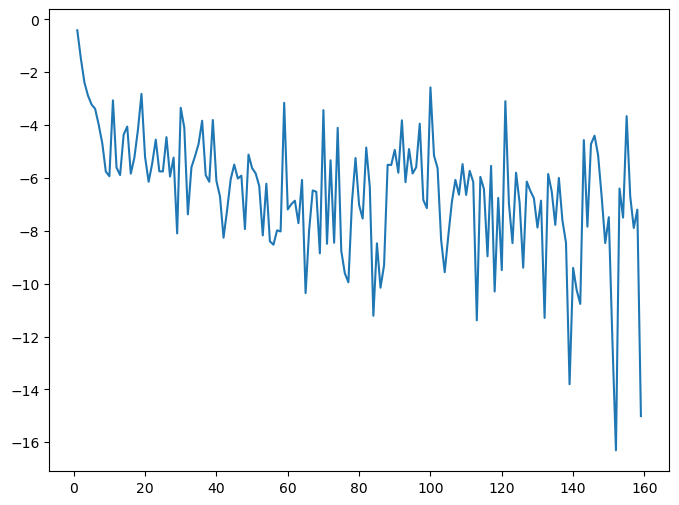

In [414]:
plt.figure(figsize=(8,6))
plt.plot(loss)

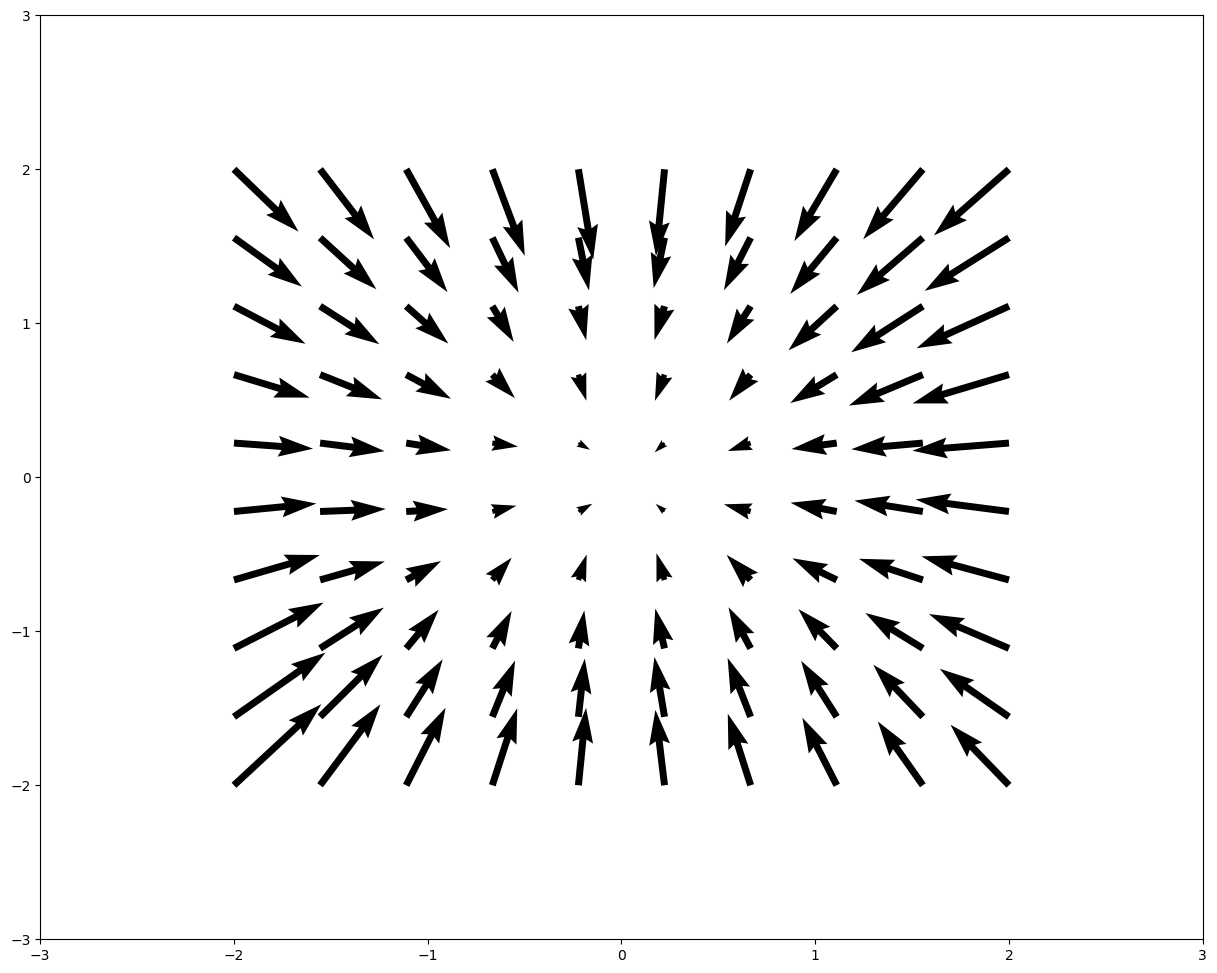

In [415]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points), 
                     X2.reshape(1, N_points, N_points))), axes=(1,2,0))
                  
grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params, jnp.hstack((x2, T))))(x1))(X)

fig = plt.figure()
plt.quiver(X1, X2, grad_log[:,:,0], grad_log[:,:,1])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.show()

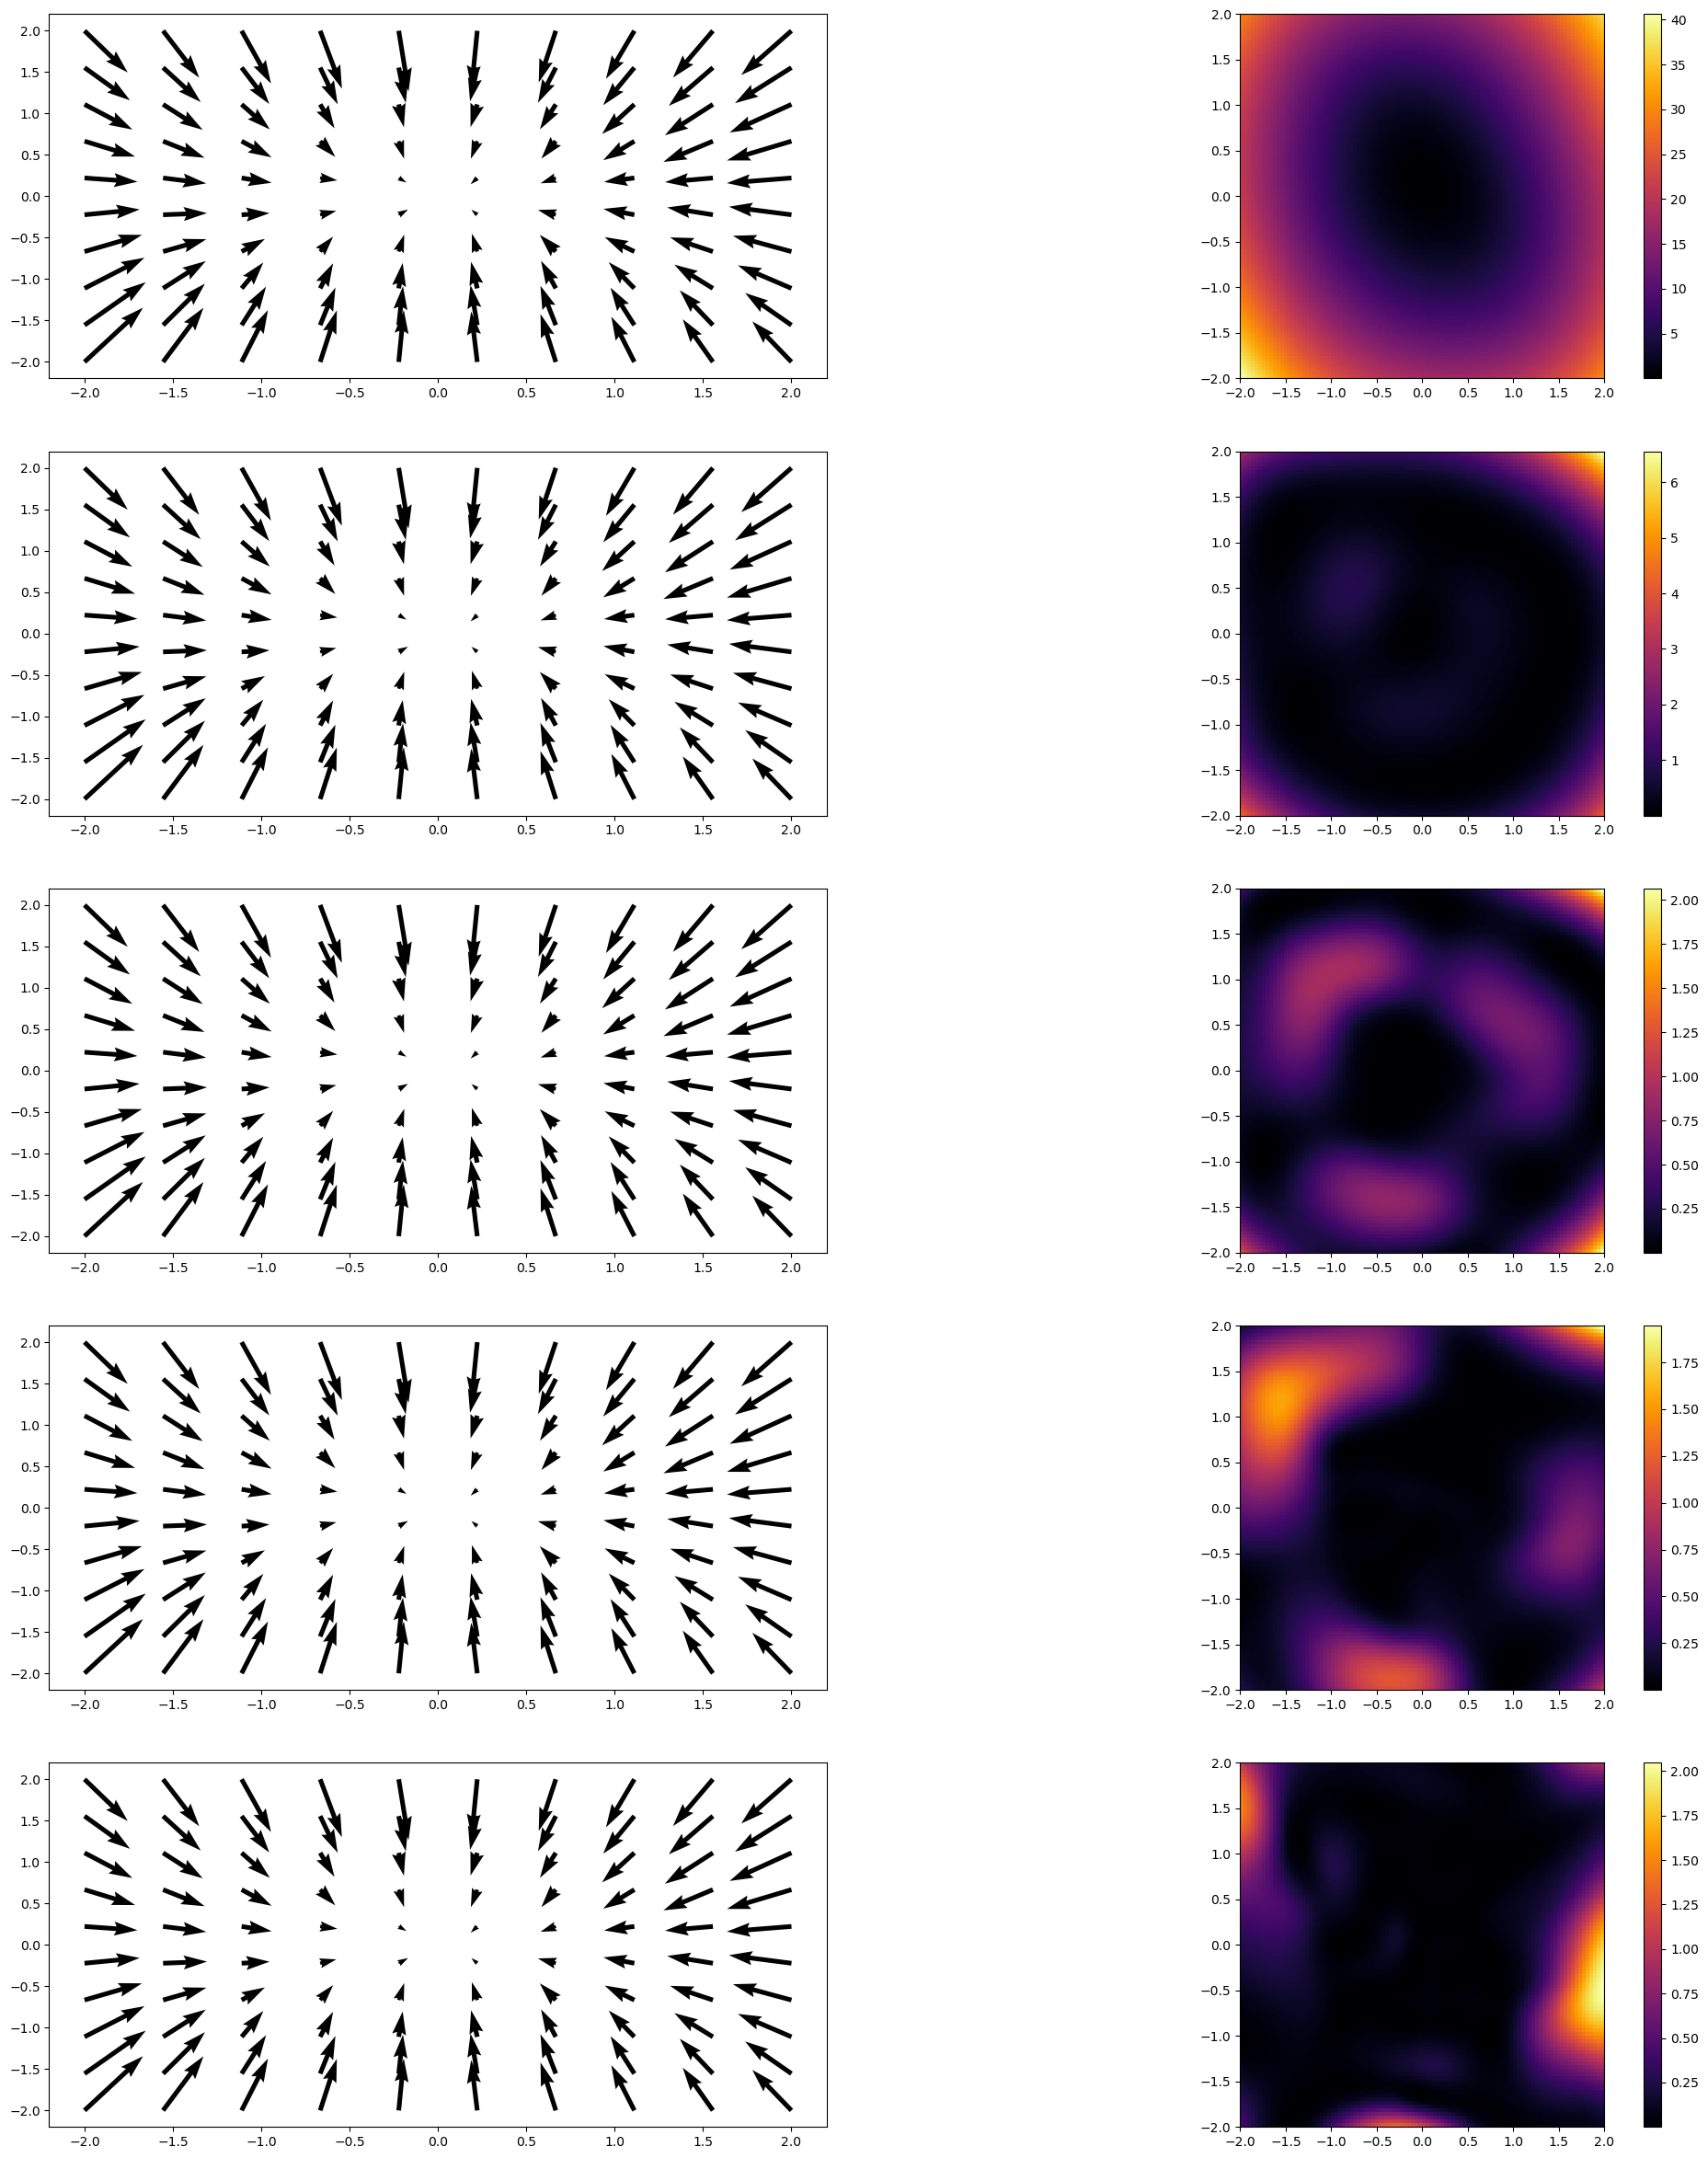

In [416]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x2, T))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(24,36))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((Fx, T)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1)
    ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2)
    ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((Fx, T)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1)
ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ general

In [417]:
#Hyper parameters
learning_rate = 0.001 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
samples_per_x0 = 2**5
ts_per_batch = 32
repeats = 2**3
batch_size = samples_per_x0*ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [418]:
global x0s
x0s = tile(x0,repeats)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = samples_per_x0*repeats
        _dts = dts(T=1.)
        global x0s
        (ts,xss,chartss,*_) = product((jnp.repeat(x0s[0],samples_per_x0,axis=0),jnp.repeat(x0s[1],samples_per_x0,axis=0)),
                                      _dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        Fx0s = x0s[0]
        x0s = (xss[-1,::samples_per_x0],chartss[-1,::samples_per_x0])
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([-1,-1])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((jnp.tile(jnp.repeat(Fx0s,samples_per_x0,axis=0),(ts_per_batch,1)),
                         samples.reshape(-1, M.dim),
                         jnp.repeat(ts,N).reshape((-1,1))
                        ))

In [419]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(50), jax.nn.tanh,
        hk.Linear(25), jax.nn.tanh,
        hk.Linear(2),
    ])
    
    y = model(x)
    
    return y

In [420]:
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params,data)
    Fx0s = data[:,0:2]
    Fxts = data[:,2:2*2]
    ts = data[:,-1]
    (xts,chartts) = jax.vmap(get_coords)(Fxts)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda Fx0,xt,chartt,t: M.div((xt,chartt),
                                                  lambda x: net.apply(params,jnp.hstack((Fx0,x[0],t))))
                   )(Fx0s,xts,chartts,ts)
    return jnp.mean(norm2s+2.0*divs)

In [421]:
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2*2+1]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: -0.434.
[Step 20], epoch 1, training loss: -0.378.
[Step 30], epoch 1, training loss: -0.615.
[Step 40], epoch 2, training loss: -0.657.
[Step 50], epoch 3, training loss: -0.785.
[Step 60], epoch 3, training loss: -0.986.
[Step 70], epoch 4, training loss: -1.188.
[Step 80], epoch 5, training loss: -1.309.
[Step 90], epoch 5, training loss: -1.669.
[Step 100], epoch 6, training loss: -1.895.
[Step 110], epoch 6, training loss: -2.358.
[Step 120], epoch 7, training loss: -2.558.
[Step 130], epoch 8, training loss: -3.003.
[Step 140], epoch 8, training loss: -3.010.
[Step 150], epoch 9, training loss: -3.269.
[Step 160], epoch 10, training loss: -3.930.
[Step 170], epoch 10, training loss: -4.074.
[Step 180], epoch 11, training loss: -3.651.
[Step 190], epoch 11, training loss: -3.621.
[Step 200], epoch 12, training loss: -4.260.
[Step 210], epoch 13, training loss: -3.932.
[Step 220], epoch 13, training loss: -3.

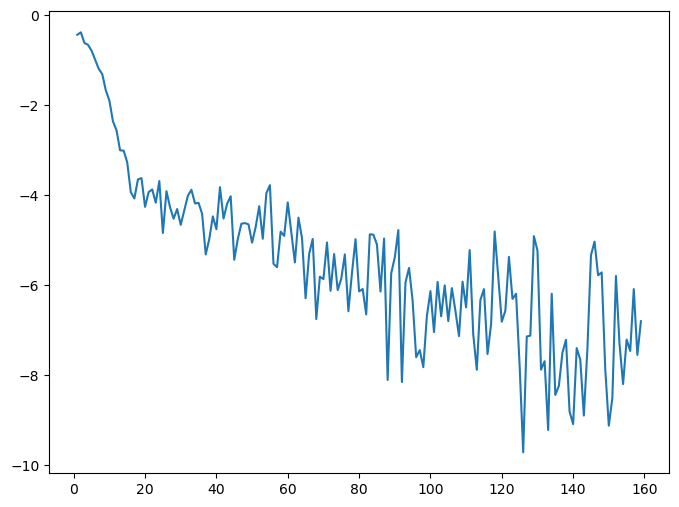

In [423]:
plt.figure(figsize=(8,6))
plt.plot(loss)

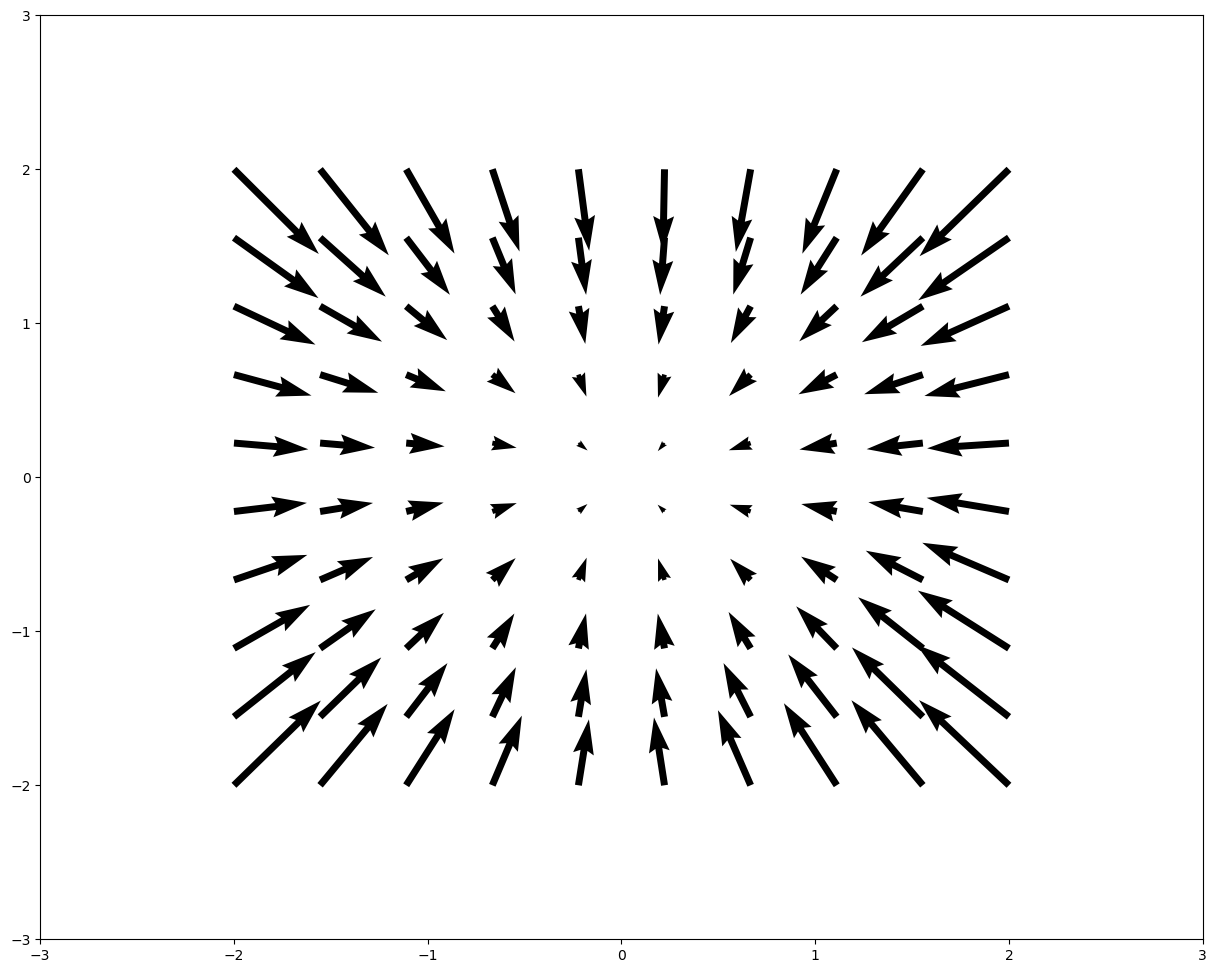

In [424]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points), 
                     X2.reshape(1, N_points, N_points))), axes=(1,2,0))
                  
grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params, jnp.hstack((x0[0], x2, T))))(x1))(X)

fig = plt.figure()
plt.quiver(X1, X2, grad_log[:,:,0], grad_log[:,:,1])
plt.xlim([-3.0, 3.0])
plt.ylim([-3.0, 3.0])
plt.show()

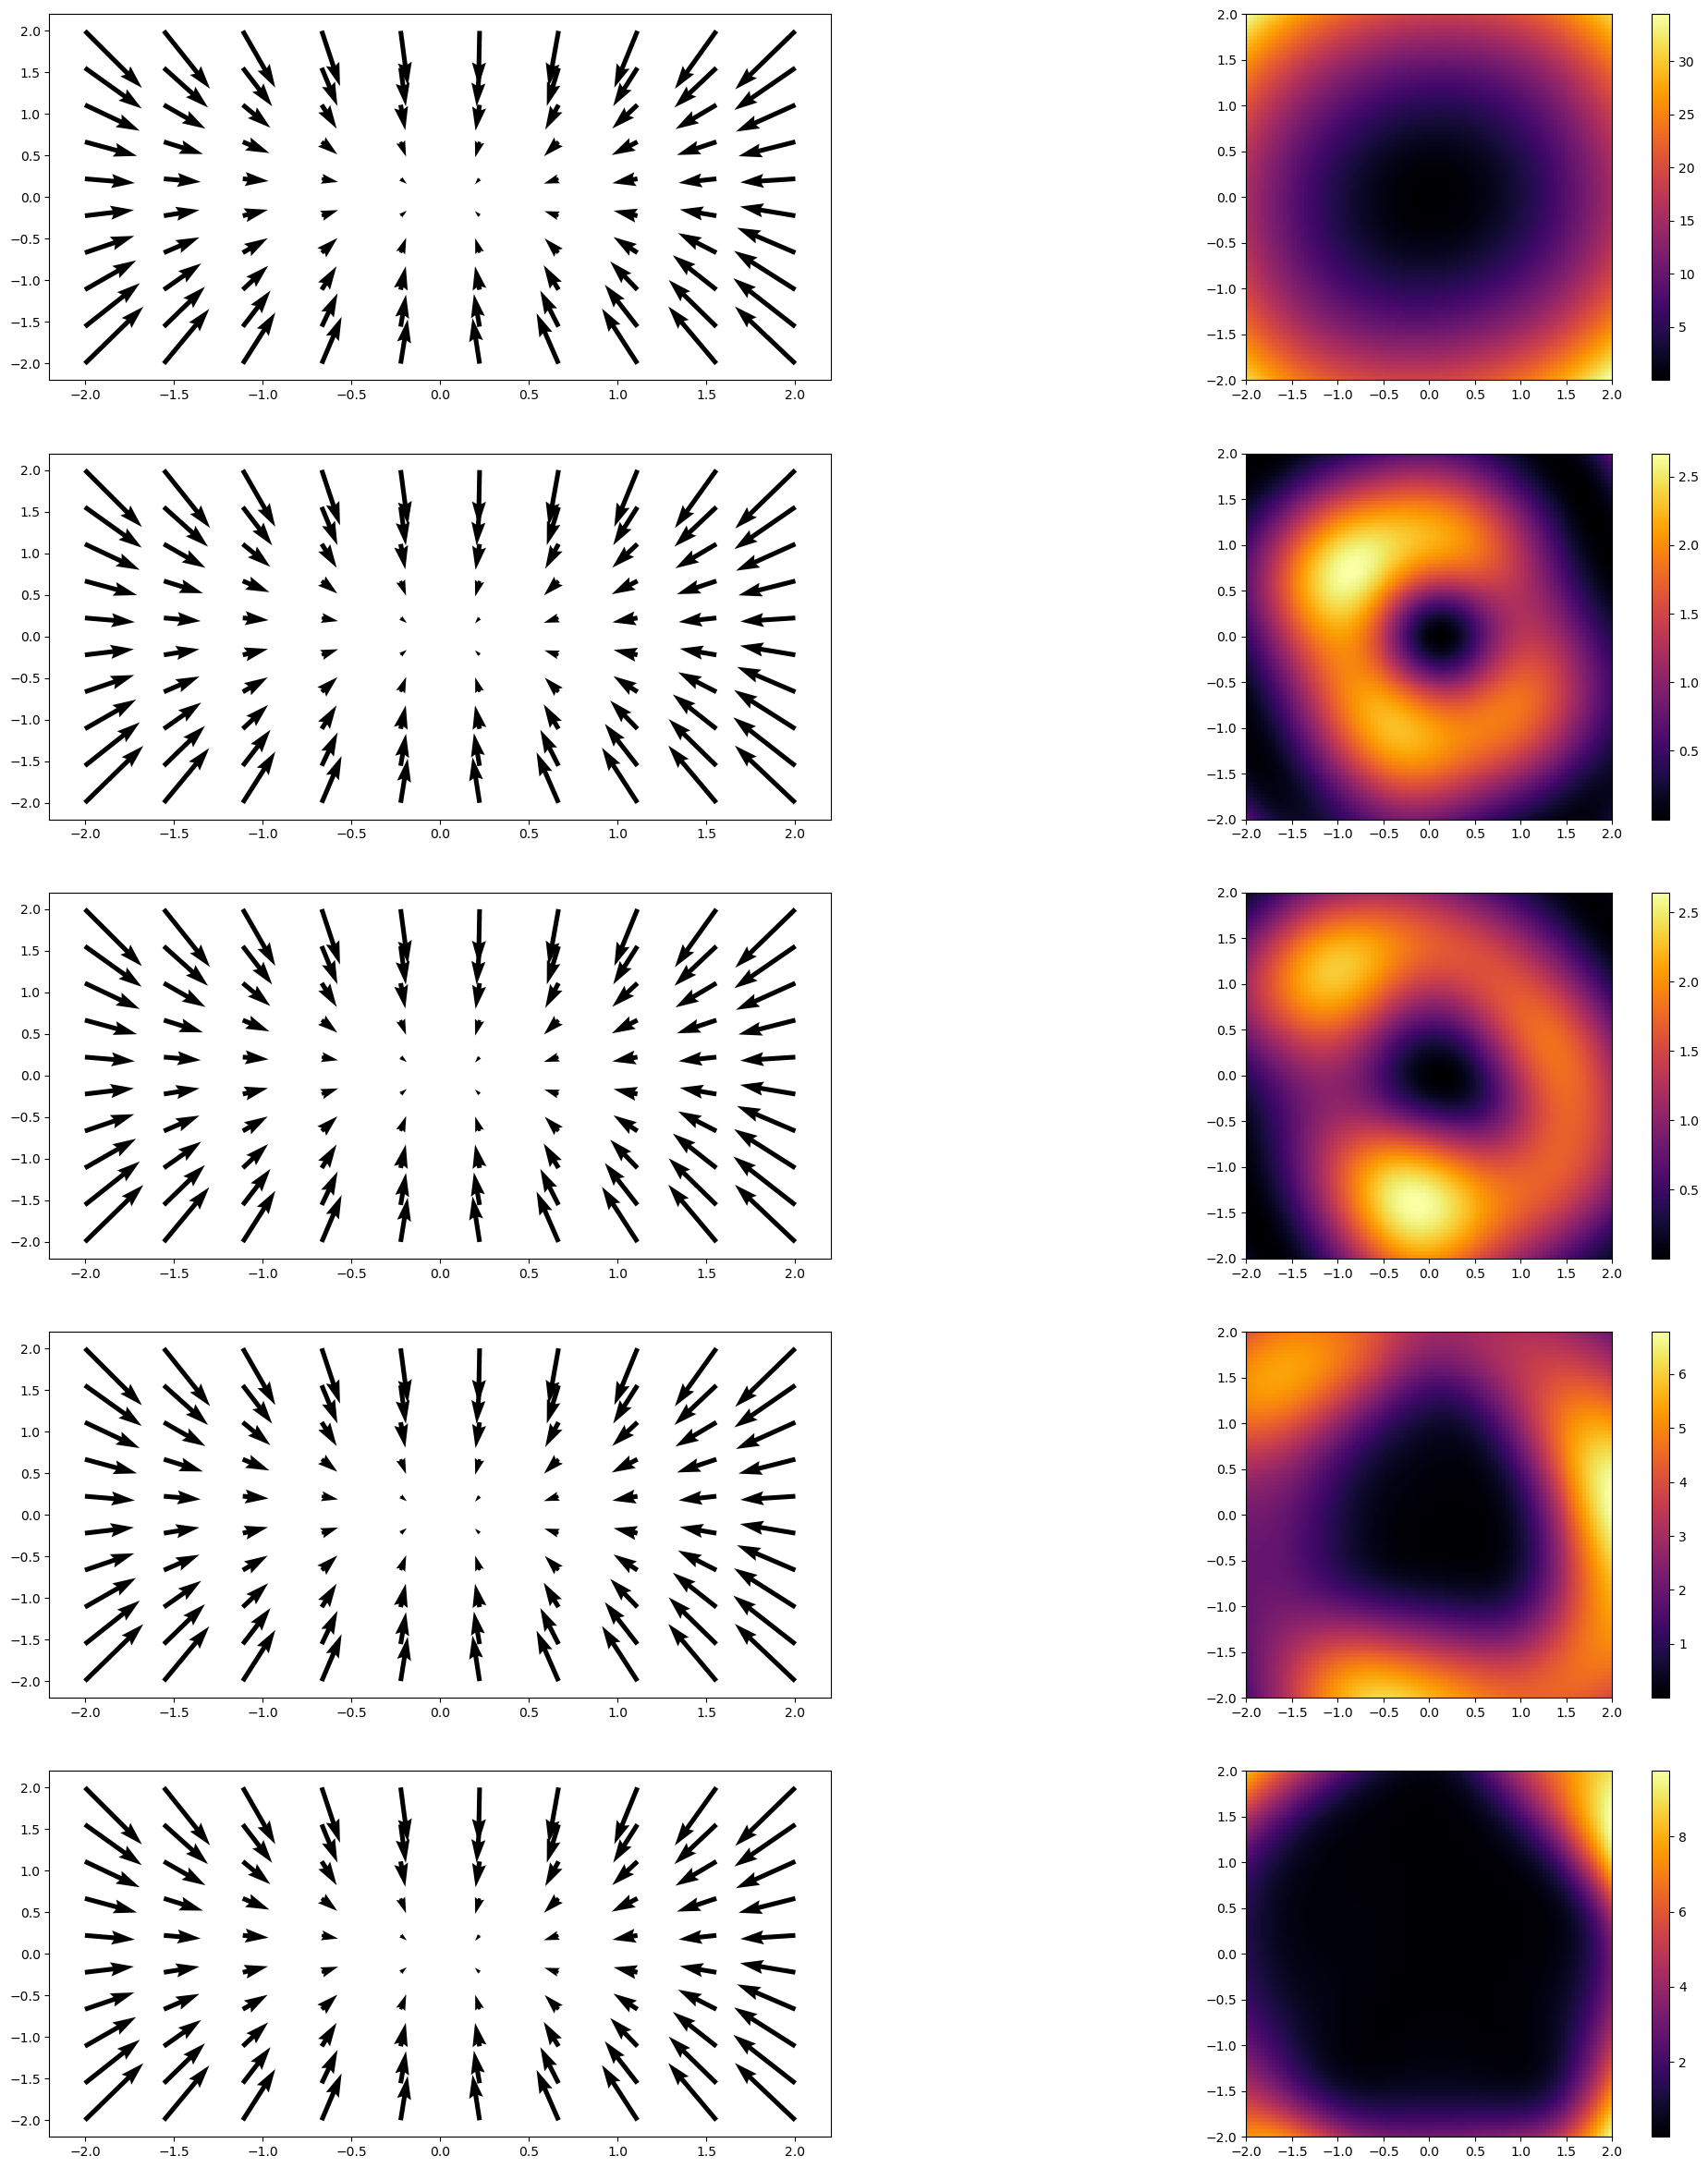

In [425]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x0[0], x2, T))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(24,36))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((x0[0], Fx, T)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1)
    ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2)
    ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((x0[0], Fx, T)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1)
ax.quiver(X1_vec, X2_vec, grad_log[:,:,0], grad_log[:,:,1])
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', extent=[-2.0,2.0,-2.0,2.0])
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

## Appendix